### Idea for denoising archetecture
0. Option: Add noise during training
1. Add attention on skip connections
2. Larger models need more time to train
3. Old model used average pooling (try max pooling)
4. Replace phase feature with MFCC or another useful feature e.g level * frequency
  a. edge detection


## 1. Using a Laplacian Filter (Edge Detection)
```python
import cv2
import numpy as np

# Apply the Laplacian filter
filtered_spectrogram = cv2.Laplacian(spectrogram, cv2.CV_64F, ksize=3)





And either use MFCC, or Cepstrum

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Environmental Sound Classification 50

In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout features")
    os.system("git pull origin features")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin features")
    os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

In [4]:
from audioautoencoder.data import *
from audioautoencoder.outputs import *
from audioautoencoder.processing import *
from audioautoencoder.training import *
from audioautoencoder.datasets.loaders import *
from audioautoencoder.generate_dataset import *
from audioautoencoder.plotting import *

test get item input and output to see if i can use the log magnitude and then reverse it on the output

## Data Generation

In [5]:
from audioautoencoder.data_management import *

In [6]:
GENERATE=False

In [7]:
# Example Usage
if GENERATE:
  dataset_dirs = ["/content/drive/MyDrive/Datasets/Noise/All_Noise"]
  output_dir = "/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2"
  splits = create_datasets(dataset_dirs, output_dir)
  print("Training Set:", len(splits["train"]))
  print("Validation Set:", len(splits["val"]))
  print("Testing Set:", len(splits["test"]))


In [8]:
if GENERATE:
  save_splits_to_directories(splits, output_dir, max_workers=8)

In [9]:
# generate audio files for noise and music (2s)
if GENERATE:
  noise_test = output_dir + "/test"
  noise_train = output_dir + "/train"

  noise_test_output = noise_test + "-2s-44100"
  noise_train_output = noise_train + "-2s-44100"

  for input_path, output_path in [(noise_test, noise_test_output), (noise_train, noise_train_output)]:
    print(input_path, output_path)
    generate_audio_files(input_path, output_path, t=2)

In [10]:
# generate audio files for noise and music (2s)
if False:
  music_test = "/content/drive/MyDrive/Datasets/Music/MUSDB18/test"
  music_train = "/content/drive/MyDrive/Datasets/Music/MUSDB18/train"

  music_test_output = music_test + "-2s-44100"
  music_train_output = music_train + "-2s-44100"

  for input_path, output_path in [(music_test, music_test_output), (music_train, music_train_output)]:
    print(input_path, output_path)
    generate_audio_files(input_path, output_path, t=2)

## Process files to H5

In [32]:
GENERATE_H5_FILES = False

if GENERATE_H5_FILES:
  checkpoint_file_size=50000
  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features',
          SNRdB=[-10, 10],
          process_train=True,
          process_test=True,
          checkpoint_file_size=checkpoint_file_size
      )
  processor.process()

  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features',
          SNRdB=[0, 20],
          process_train=True,
          process_test=True,
          checkpoint_file_size=checkpoint_file_size
      )
  processor.process()

  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features',
          SNRdB=[10, 30],
          process_train=True,
          process_test=True,
          checkpoint_file_size=checkpoint_file_size
      )
  processor.process()

  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features',
          SNRdB=[-10, 30],
          process_train=True,
          process_test=True,
          mix_only=True,
          checkpoint_file_size=checkpoint_file_size
      )
  processor.process()

Output Dir: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features
Train Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train-SNRdB_-10-10-checkpoint.txt
Train Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10.h5
Test Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test-SNRdB_-10-10-checkpoint.txt
Test Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10.h5
Directory already exists: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train
Directory already exists: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test
Processing training dataset....
Gathering wav files....
Error accessing directory: [Errno 5] Input/output error: '/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100'
Files processed:  46733
Gat

Processing batches:   0%|          | 0/85 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_mixture_sec70.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_mixture_sec116.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_bass_sec56.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_drums_sec276.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_bass_sec88.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/

Processing batches:   1%|          | 1/85 [05:51<8:11:43, 351.23s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224015.h5
Free disk space: 176.66 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/St Vitus - Word Gets Around_vocals_sec64.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:   2%|▏         | 2/85 [06:53<4:10:59, 181.44s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224457.h5
Free disk space: 175.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_other_sec52.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec314.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_bass_sec10.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:   4%|▎         | 3/85 [07:50<2:49:59, 124.38s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224559.h5
Free disk space: 173.70 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec132.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_mixture_sec188.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_drums_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_vocals_sec196.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:   5%|▍         | 4/85 [08:45<2:10:56, 96.99s/batch] 

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224654.h5
Free disk space: 172.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_bass_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_mixture_sec56.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Grunge_drums_sec42.wav: operands could not be broadcast together with shapes (88200,) (81768,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_mixture_sec264.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:   6%|▌         | 5/85 [09:37<1:47:58, 80.99s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224748.h5
Free disk space: 170.74 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec124.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec250.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_vocals_sec38.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_vocals_sec98.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error process

Processing batches:   7%|▋         | 6/85 [10:29<1:33:38, 71.11s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224840.h5
Free disk space: 169.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec10.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_other_sec186.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_other_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_drums_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datase

Processing batches:   8%|▊         | 7/85 [11:22<1:24:41, 65.15s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_224933.h5
Free disk space: 167.79 GB
Creating HDF5 file....


Processing batches:   9%|▉         | 8/85 [12:16<1:19:07, 61.65s/batch]

Current file size: 1.4017831236124039
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225026.h5
Free disk space: 166.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Night Panther - Fire_other_sec190.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_other_sec50.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_bass_sec234.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_drums_sec208.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Creating HDF5 file....


Processing batches:  11%|█         | 9/85 [13:09<1:14:22, 58.72s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225119.h5
Free disk space: 164.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_bass_sec162.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  12%|█▏        | 10/85 [14:04<1:11:54, 57.52s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225212.h5
Free disk space: 163.34 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_mixture_sec52.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec296.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec42.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - The Wind_drums_sec144.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  13%|█▎        | 11/85 [14:56<1:09:12, 56.12s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225307.h5
Free disk space: 161.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_bass_sec384.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_mixture_sec4.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Gospel_drums_sec76.wav: operands could not be broadcast together with shapes (88200,) (76615,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_mixture_sec10.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processin

Processing batches:  14%|█▍        | 12/85 [16:00<1:10:53, 58.27s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225403.h5
Free disk space: 160.40 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_vocals_sec250.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_mixture_sec16.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec164.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - 80s Rock_vocals_sec6.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file.

Processing batches:  15%|█▌        | 13/85 [16:54<1:08:38, 57.21s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225504.h5
Free disk space: 158.92 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_bass_sec134.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_other_sec140.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_vocals_sec140.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  16%|█▋        | 14/85 [17:48<1:06:14, 55.98s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225558.h5
Free disk space: 157.45 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_other_sec14.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_vocals_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_bass_sec16.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_mixture_sec480.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF5

Processing batches:  18%|█▊        | 15/85 [18:42<1:04:36, 55.38s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225652.h5
Free disk space: 155.97 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_mixture_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_mixture_sec74.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Hendrix_bass_sec2.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_drums_sec196.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  19%|█▉        | 16/85 [19:33<1:02:17, 54.17s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225743.h5
Free disk space: 155.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_bass_sec166.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Beatles_other_sec22.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_vocals_sec180.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  20%|██        | 17/85 [20:29<1:02:03, 54.75s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225839.h5
Free disk space: 155.79 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec138.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_mixture_sec4.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_bass_sec380.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_other_sec56.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 fi

Processing batches:  21%|██        | 18/85 [21:20<59:50, 53.59s/batch]  

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_225930.h5
Free disk space: 155.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/AvaLuna - Waterduct_mixture_sec118.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_mixture_sec378.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec200.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  22%|██▏       | 19/85 [22:14<59:13, 53.85s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230024.h5
Free disk space: 155.70 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_mixture_sec182.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_bass_sec28.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_mixture_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_bass_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /conte

Processing batches:  24%|██▎       | 20/85 [23:19<1:01:48, 57.05s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230126.h5
Free disk space: 155.68 GB
Creating HDF5 file....


Processing batches:  25%|██▍       | 21/85 [24:20<1:02:16, 58.39s/batch]

Current file size: 1.4017831236124039
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230229.h5
Free disk space: 155.57 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_mixture_sec104.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Night Panther - Fire_drums_sec180.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_other_sec240.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_bass_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/dri

Processing batches:  26%|██▌       | 22/85 [25:18<1:01:02, 58.13s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230328.h5
Free disk space: 155.58 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_bass_sec184.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - On The Line_vocals_sec12.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec212.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_bass_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Creating HDF5 file....


Processing batches:  27%|██▋       | 23/85 [26:30<1:04:15, 62.19s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230429.h5
Free disk space: 155.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_vocals_sec90.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_bass_sec110.wav: operands could not be broadcast together with shapes (74376,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_mixture_sec224.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Facade_drums_sec58.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing

Processing batches:  28%|██▊       | 24/85 [27:31<1:03:03, 62.03s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230540.h5
Free disk space: 155.46 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_other_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_other_sec4.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_mixture_sec118.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_mixture_sec150.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  29%|██▉       | 25/85 [28:31<1:01:21, 61.35s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230640.h5
Free disk space: 155.47 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec238.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_drums_sec174.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_bass_sec130.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_other_sec128.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processin

Processing batches:  31%|███       | 26/85 [29:30<59:33, 60.56s/batch]  

Current file size: 1.3765532933175564
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230740.h5
Free disk space: 155.39 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_vocals_sec240.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/AvaLuna - Waterduct_drums_sec194.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Tim Taler - Stalker_bass_sec42.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Creating HDF5 file....


Processing batches:  32%|███▏      | 27/85 [30:34<59:46, 61.84s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230843.h5
Free disk space: 155.35 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_vocals_sec164.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec120.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  33%|███▎      | 28/85 [31:37<58:52, 61.98s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_230947.h5
Free disk space: 155.46 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_drums_sec102.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_other_sec54.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_drums_sec164.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  34%|███▍      | 29/85 [32:40<58:12, 62.37s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231050.h5
Free disk space: 155.38 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec208.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Whisper To A Scream_bass_sec56.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_bass_sec232.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_mixture_sec104.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processin

Processing batches:  35%|███▌      | 30/85 [33:43<57:27, 62.68s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231154.h5
Free disk space: 155.39 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_drums_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_other_sec176.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  36%|███▋      | 31/85 [34:48<57:01, 63.36s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231257.h5
Free disk space: 155.34 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_drums_sec46.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_other_sec170.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Creating HDF5 file....


Processing batches:  38%|███▊      | 32/85 [35:50<55:35, 62.93s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231400.h5
Free disk space: 155.36 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_mixture_sec96.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec164.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_mixture_sec64.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_mixture_sec200.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Creating HDF5 file

Processing batches:  39%|███▉      | 33/85 [37:04<57:15, 66.07s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231506.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_mixture_sec18.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Nos Palpitants_drums_sec154.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /conte

Processing batches:  40%|████      | 34/85 [38:06<55:14, 64.98s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231616.h5
Free disk space: 155.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_drums_sec152.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Snowmine - Curfews_vocals_sec32.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_bass_sec110.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_other_sec166.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datas

Processing batches:  41%|████      | 35/85 [39:11<54:07, 64.96s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231722.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_drums_sec88.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_mixture_sec476.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_bass_sec34.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec340.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF5 file....


Processing batches:  42%|████▏     | 36/85 [40:12<52:09, 63.87s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231823.h5
Free disk space: 155.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_bass_sec144.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_other_sec180.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  44%|████▎     | 37/85 [41:15<50:45, 63.46s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_231925.h5
Free disk space: 155.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_bass_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_drums_sec88.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_bass_sec6.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_mixture_sec38.wav: operands could not be broadcast together with shapes (74376,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  45%|████▍     | 38/85 [42:20<50:07, 63.99s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232029.h5
Free disk space: 155.45 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_bass_sec84.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_vocals_sec250.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Invisible Familiars - Disturbing Wildlife_other_sec14.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_other_sec38.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Creating HDF5

Processing batches:  46%|████▌     | 39/85 [43:24<49:01, 63.95s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232134.h5
Free disk space: 155.43 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_drums_sec14.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_other_sec222.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_vocals_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_other_sec126.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /cont

Processing batches:  47%|████▋     | 40/85 [44:28<47:55, 63.90s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232238.h5
Free disk space: 155.43 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_bass_sec300.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_drums_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_bass_sec96.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec176.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:  48%|████▊     | 41/85 [45:30<46:33, 63.48s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232341.h5
Free disk space: 155.37 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_vocals_sec162.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_mixture_sec32.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_drums_sec134.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Matthew Entwistle - Dont You Ever_vocals_sec72.wav: operands could not be broadcast together with shapes (77747,) (88200

Processing batches:  49%|████▉     | 42/85 [46:34<45:37, 63.66s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232443.h5
Free disk space: 155.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec86.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_other_sec232.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_other_sec32.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  51%|█████     | 43/85 [47:45<46:05, 65.85s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232550.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_other_sec24.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_bass_sec66.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_bass_sec130.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_vocals_sec282.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Creating HDF5 file....


Processing batches:  52%|█████▏    | 44/85 [48:53<45:22, 66.40s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232659.h5
Free disk space: 155.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_other_sec182.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Creating HDF5 file....


Processing batches:  53%|█████▎    | 45/85 [49:57<43:44, 65.61s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232807.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_bass_sec96.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  54%|█████▍    | 46/85 [51:01<42:17, 65.07s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_232909.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_bass_sec226.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_drums_sec32.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  55%|█████▌    | 47/85 [52:06<41:14, 65.13s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233014.h5
Free disk space: 155.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_bass_sec194.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_drums_sec126.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_drums_sec270.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/dri

Processing batches:  56%|█████▋    | 48/85 [53:10<40:00, 64.88s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233120.h5
Free disk space: 155.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_bass_sec294.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_other_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Tim Taler - Stalker_other_sec46.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  58%|█████▊    | 49/85 [54:14<38:44, 64.56s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233224.h5
Free disk space: 155.42 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_other_sec120.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  59%|█████▉    | 50/85 [55:17<37:26, 64.19s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233327.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec116.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_other_sec546.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  60%|██████    | 51/85 [56:22<36:24, 64.25s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233432.h5
Free disk space: 155.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_mixture_sec204.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_vocals_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_drums_sec176.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Come Around_vocals_sec254.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /cont

Processing batches:  61%|██████    | 52/85 [57:23<34:53, 63.45s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233533.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_bass_sec186.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_drums_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_other_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_mixture_sec94.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /conte

Processing batches:  62%|██████▏   | 53/85 [58:37<35:31, 66.62s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233642.h5
Free disk space: 155.11 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Disco_drums_sec26.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Swinging Steaks - Lost My Way_other_sec142.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Dorothy_bass_sec168.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Creating HDF5 file....


Processing batches:  64%|██████▎   | 54/85 [59:43<34:20, 66.48s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233752.h5
Free disk space: 155.35 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dark Ride - Burning Bridges_drums_sec74.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_bass_sec100.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  65%|██████▍   | 55/85 [1:00:49<33:06, 66.21s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_233858.h5
Free disk space: 155.38 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_drums_sec92.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Matthew Entwistle - Dont You Ever_other_sec2.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_mixture_sec152.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  66%|██████▌   | 56/85 [1:01:52<31:33, 65.28s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234002.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Wicked_vocals_sec166.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_other_sec346.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  67%|██████▋   | 57/85 [1:02:54<30:01, 64.34s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234104.h5
Free disk space: 155.28 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_drums_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_mixture_sec98.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec196.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  68%|██████▊   | 58/85 [1:03:59<28:59, 64.42s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234207.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Facade_vocals_sec50.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_other_sec234.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Come Around_other_sec156.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  69%|██████▉   | 59/85 [1:05:01<27:35, 63.66s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234311.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_mixture_sec42.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  71%|███████   | 60/85 [1:06:03<26:22, 63.31s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234413.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_other_sec398.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_mixture_sec128.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dark Ride - Burning Bridges_other_sec118.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_other_sec218.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /cont

Processing batches:  72%|███████▏  | 61/85 [1:07:11<25:51, 64.64s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234521.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_bass_sec148.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec184.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_other_sec76.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_bass_sec194.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Creating HDF5 file....


Processing batches:  73%|███████▎  | 62/85 [1:08:19<25:07, 65.56s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234625.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_other_sec218.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_bass_sec154.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_drums_sec60.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_other_sec2.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive

Processing batches:  74%|███████▍  | 63/85 [1:09:34<25:06, 68.49s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234739.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_bass_sec34.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_other_sec232.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_vocals_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec174.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Creating HDF5 file....


Processing batches:  75%|███████▌  | 64/85 [1:10:37<23:22, 66.80s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234847.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_drums_sec242.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_drums_sec26.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Facade_mixture_sec6.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file.

Processing batches:  76%|███████▋  | 65/85 [1:11:40<21:54, 65.75s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_234950.h5
Free disk space: 155.32 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_vocals_sec148.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_bass_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_mixture_sec92.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  78%|███████▊  | 66/85 [1:12:43<20:33, 64.91s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235054.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_vocals_sec174.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec220.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_other_sec34.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_drums_sec380.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /conte

Processing batches:  79%|███████▉  | 67/85 [1:13:46<19:16, 64.24s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235154.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_other_sec48.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Creating HDF5 file....


Processing batches:  80%|████████  | 68/85 [1:14:50<18:13, 64.31s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235300.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_bass_sec30.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Dorothy_mixture_sec116.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_bass_sec136.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Creating HDF5 file....


Processing batches:  81%|████████  | 69/85 [1:15:54<17:06, 64.17s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235404.h5
Free disk space: 155.28 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_vocals_sec136.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_other_sec136.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error process

Processing batches:  82%|████████▏ | 70/85 [1:16:58<16:03, 64.22s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235509.h5
Free disk space: 155.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/A Classic Education - NightOwl_drums_sec56.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Grunge_mixture_sec42.wav: operands could not be broadcast together with shapes (88200,) (81768,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_bass_sec126.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Creating HDF5 file....


Processing batches:  84%|████████▎ | 71/85 [1:18:03<14:58, 64.17s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235613.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_vocals_sec126.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hollow Ground - Left Blind_bass_sec68.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Facade_drums_sec42.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_other_sec248.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Creating HDF5 file....


Processing batches:  85%|████████▍ | 72/85 [1:19:20<14:47, 68.25s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235720.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_bass_sec132.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_drums_sec274.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_bass_sec40.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_vocals_sec156.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUS

Processing batches:  86%|████████▌ | 73/85 [1:20:32<13:51, 69.31s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235840.h5
Free disk space: 155.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Chris Durban - Celebrate_vocals_sec58.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_drums_sec26.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec142.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Night Panther - Fire_bass_sec170.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Creating HDF5 file....


Processing batches:  87%|████████▋ | 74/85 [1:21:38<12:30, 68.22s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250224_235948.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_bass_sec154.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_drums_sec224.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_other_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_vocals_sec290.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF5 file....


Processing batches:  88%|████████▊ | 75/85 [1:22:41<11:07, 66.76s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000051.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_drums_sec196.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_drums_sec76.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:  89%|████████▉ | 76/85 [1:23:44<09:50, 65.65s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000154.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_other_sec98.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_drums_sec172.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_drums_sec58.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_drums_sec236.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDri

Processing batches:  91%|█████████ | 77/85 [1:24:49<08:43, 65.44s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000259.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_other_sec82.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_drums_sec138.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_other_sec42.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  92%|█████████▏| 78/85 [1:25:53<07:35, 65.05s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000403.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_other_sec44.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec218.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_other_sec146.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_bass_sec14.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/driv

Processing batches:  93%|█████████▎| 79/85 [1:26:59<06:31, 65.18s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000509.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_bass_sec34.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_mixture_sec2.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_other_sec172.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_drums_sec158.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  94%|█████████▍| 80/85 [1:28:08<05:32, 66.44s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000615.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_bass_sec170.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_vocals_sec230.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_drums_sec112.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_vocals_sec218.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  95%|█████████▌| 81/85 [1:29:19<04:31, 67.84s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000725.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_drums_sec224.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  96%|█████████▋| 82/85 [1:30:32<03:27, 69.20s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000837.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_drums_sec128.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_mixture_sec12.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_other_sec218.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_other_sec212.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/My

Processing batches:  98%|█████████▊| 83/85 [1:31:40<02:18, 69.07s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_000950.h5
Free disk space: 155.42 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_mixture_sec66.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_vocals_sec82.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_other_sec270.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_mixture_sec108.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error proces

Processing batches:  99%|█████████▉| 84/85 [1:32:46<01:08, 68.05s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250225_001055.h5
Free disk space: 155.35 GB
Creating HDF5 file....
File maximum samples file......


Processing batches:  99%|█████████▉| 84/85 [1:33:38<01:06, 66.89s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/train/train-SNRdB_-10-10.h5
Processing testing dataset....
Gathering wav files....
Files processed:  25641
Gathering noise files....
Files processed:  1564
Checkpoint file path: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test-SNRdB_-10-10-checkpoint.txt
Error reading file: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test-SNRdB_-10-10-checkpoint.txt'
Resuming from batch index: 0


Processing batches:   0%|          | 0/52 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec164.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec62.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_bass_sec154.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises (Baumi) - SDRNR_vocals_sec224.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Creating HDF5 file....


Processing batches:   2%|▏         | 1/52 [02:29<2:07:23, 149.87s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_001556.h5
Free disk space: 155.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_mixture_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_bass_sec238.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_other_sec134.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises (Baumi) - SDRNR_other_sec218.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing

Processing batches:   4%|▍         | 2/52 [03:28<1:20:11, 96.23s/batch] 

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_001656.h5
Free disk space: 155.84 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_bass_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_bass_sec44.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_drums_sec140.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec194.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:   6%|▌         | 3/52 [04:29<1:05:27, 80.16s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_001755.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_drums_sec124.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_drums_sec238.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_bass_sec170.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_drums_sec164.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Creating HDF5 file....


Processing batches:   8%|▊         | 4/52 [05:38<1:00:42, 75.89s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_001902.h5
Free disk space: 155.91 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_vocals_sec150.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec94.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_vocals_sec10.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec50.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error process

Processing batches:  10%|▉         | 5/52 [06:40<55:23, 70.72s/batch]  

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002006.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_drums_sec38.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_other_sec350.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_vocals_sec94.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_mixture_sec262.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/

Processing batches:  12%|█▏        | 6/52 [07:44<52:27, 68.43s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002112.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_bass_sec210.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec280.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_other_sec112.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec134.wav: operands could not be broadcast together with shapes (77819,) (88200,)

Processing batches:  13%|█▎        | 7/52 [08:42<48:43, 64.96s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002209.h5
Free disk space: 155.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec260.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_vocals_sec140.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_drums_sec122.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /co

Processing batches:  15%|█▌        | 8/52 [09:41<46:18, 63.15s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002308.h5
Free disk space: 155.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Happy Daze_mixture_sec134.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_vocals_sec106.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_bass_sec122.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_vocals_sec174.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Dataset

Processing batches:  17%|█▋        | 9/52 [10:40<44:20, 61.88s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002406.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_drums_sec18.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_drums_sec196.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_mixture_sec228.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_vocals_sec104.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /

Processing batches:  19%|█▉        | 10/52 [11:37<42:12, 60.31s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002505.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_vocals_sec140.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_vocals_sec96.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_mixture_sec118.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Lyndsey Ollard - Catching Up_bass_sec82.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /conten

Processing batches:  21%|██        | 11/52 [12:33<40:18, 58.98s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002601.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_mixture_sec158.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_drums_sec32.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec78.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_mixture_sec144.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/driv

Processing batches:  23%|██▎       | 12/52 [13:32<39:17, 58.94s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002659.h5
Free disk space: 154.63 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_drums_sec160.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Too Much_vocals_sec92.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec80.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec118.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/

Processing batches:  25%|██▌       | 13/52 [14:29<37:55, 58.35s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002756.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_vocals_sec72.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_bass_sec28.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_other_sec254.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_drums_sec68.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/

Processing batches:  27%|██▋       | 14/52 [15:29<37:21, 58.99s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_002854.h5
Free disk space: 154.58 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_mixture_sec224.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec126.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/James Elder & Mark M Thompson - The English Actor_bass_sec78.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec48.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /conte

Processing batches:  29%|██▉       | 15/52 [16:37<37:57, 61.55s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003001.h5
Free disk space: 154.57 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec12.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_other_sec210.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_vocals_sec96.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec146.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/

Processing batches:  31%|███       | 16/52 [17:35<36:18, 60.52s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003103.h5
Free disk space: 154.79 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_other_sec284.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_bass_sec238.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_vocals_sec370.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  33%|███▎      | 17/52 [18:34<35:05, 60.17s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003202.h5
Free disk space: 154.76 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_drums_sec110.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_bass_sec122.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_other_sec70.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_mixture_sec68.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processi

Processing batches:  35%|███▍      | 18/52 [19:31<33:34, 59.25s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003259.h5
Free disk space: 154.71 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_drums_sec82.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_mixture_sec86.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_other_sec234.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_drums_sec20.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Mus

Processing batches:  37%|███▋      | 19/52 [20:28<32:06, 58.39s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003355.h5
Free disk space: 154.80 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec106.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_mixture_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_other_sec130.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_mixture_sec74.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/dr

Processing batches:  38%|███▊      | 20/52 [21:24<30:50, 57.84s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003452.h5
Free disk space: 154.93 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_other_sec236.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_mixture_sec112.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_drums_sec290.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_other_sec74.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/

Processing batches:  40%|████      | 21/52 [22:21<29:43, 57.55s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003549.h5
Free disk space: 154.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_drums_sec166.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_other_sec156.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_vocals_sec58.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec38.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /cont

Processing batches:  42%|████▏     | 22/52 [23:19<28:50, 57.68s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003646.h5
Free disk space: 154.92 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_vocals_sec146.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec190.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_other_sec146.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_vocals_sec136.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error proces

Processing batches:  44%|████▍     | 23/52 [24:16<27:44, 57.41s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003744.h5
Free disk space: 154.89 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Happy Daze_drums_sec158.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_mixture_sec22.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_other_sec250.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_vocals_sec144.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datas

Processing batches:  46%|████▌     | 24/52 [25:14<26:52, 57.59s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003842.h5
Free disk space: 155.81 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_bass_sec80.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_drums_sec146.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Motor Tapes - Shore_other_sec112.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_mixture_sec126.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  48%|████▊     | 25/52 [26:16<26:35, 59.08s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_003940.h5
Free disk space: 155.88 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Mu - Too Bright_mixture_sec44.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_bass_sec20.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec222.wav: operands could not be broadcast together with shapes (88200,) (70481,) 
Creating HDF5 file....


Processing batches:  50%|█████     | 26/52 [27:23<26:31, 61.21s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004046.h5
Free disk space: 155.84 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec28.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec42.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_other_sec4.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec206.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /c

Processing batches:  52%|█████▏    | 27/52 [28:20<24:59, 59.99s/batch]

Current file size: 1.3765532933175564
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004148.h5
Free disk space: 155.86 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_other_sec194.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec154.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec262.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_other_sec96.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Dataset

Processing batches:  54%|█████▍    | 28/52 [29:21<24:11, 60.50s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004245.h5
Free disk space: 155.80 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Carlos Gonzalez - A Place For Us_drums_sec206.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_drums_sec194.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_other_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec24.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/

Processing batches:  56%|█████▌    | 29/52 [30:24<23:23, 61.04s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004351.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec196.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_vocals_sec186.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec28.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_drums_sec318.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error 

Processing batches:  58%|█████▊    | 30/52 [31:24<22:19, 60.91s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004453.h5
Free disk space: 155.91 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec236.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec60.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_other_sec198.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_other_sec180.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Da

Processing batches:  60%|█████▉    | 31/52 [32:20<20:48, 59.44s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004549.h5
Free disk space: 155.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_drums_sec230.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_other_sec244.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_vocals_sec96.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_vocals_sec114.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets

Processing batches:  62%|██████▏   | 32/52 [33:18<19:37, 58.87s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004645.h5
Free disk space: 155.90 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_bass_sec168.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/James Elder & Mark M Thompson - The English Actor_mixture_sec26.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  63%|██████▎   | 33/52 [34:15<18:30, 58.46s/batch]

Current file size: 1.396180309355259
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004744.h5
Free disk space: 155.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_vocals_sec238.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec428.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec94.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_mixture_sec202.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive

Processing batches:  65%|██████▌   | 34/52 [35:12<17:20, 57.81s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004840.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec200.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec32.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_bass_sec76.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec252.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive

Processing batches:  67%|██████▋   | 35/52 [36:09<16:18, 57.58s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_004937.h5
Free disk space: 155.79 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_mixture_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec214.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Tom McKenzie - Directions_mixture_sec32.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_vocals_sec50.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/M

Processing batches:  69%|██████▉   | 36/52 [37:19<16:22, 61.43s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005040.h5
Free disk space: 155.90 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_bass_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_other_sec132.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Creating HDF5 file....


Processing batches:  71%|███████   | 37/52 [38:17<15:03, 60.23s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005144.h5
Free disk space: 155.84 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Oh No_bass_sec14.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Signe Jakobsen - What Have You Done To Me_mixture_sec80.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_vocals_sec104.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_vocals_sec38.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyD

Processing batches:  73%|███████▎  | 38/52 [39:18<14:10, 60.73s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005247.h5
Free disk space: 155.79 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec156.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_vocals_sec296.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_vocals_sec138.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec168.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Creating HDF5 file....


Processing batches:  75%|███████▌  | 39/52 [40:23<13:25, 61.93s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005345.h5
Free disk space: 155.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec44.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec232.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_drums_sec28.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec12.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  77%|███████▋  | 40/52 [41:21<12:07, 60.63s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005449.h5
Free disk space: 155.85 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Carlos Gonzalez - A Place For Us_drums_sec102.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec162.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_other_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_other_sec174.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/dr

Processing batches:  79%|███████▉  | 41/52 [42:19<10:59, 59.92s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005547.h5
Free disk space: 155.79 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_other_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_drums_sec16.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_bass_sec118.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_bass_sec80.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Mus

Processing batches:  81%|████████  | 42/52 [43:16<09:49, 58.91s/batch]

Current file size: 1.3849670514464378
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005644.h5
Free disk space: 155.74 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_mixture_sec90.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_bass_sec212.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Sunshine Garcia Band - For I Am The Moon_drums_sec104.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Creating HDF5 file....


Processing batches:  83%|████████▎ | 43/52 [44:12<08:44, 58.25s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005740.h5
Free disk space: 155.67 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_mixture_sec150.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_bass_sec58.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec228.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_drums_sec86.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/

Processing batches:  85%|████████▍ | 44/52 [45:09<07:43, 57.91s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005838.h5
Free disk space: 155.73 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec20.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_drums_sec192.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_drums_sec210.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_other_sec142.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/My

Processing batches:  87%|████████▋ | 45/52 [46:09<06:48, 58.38s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_005935.h5
Free disk space: 155.71 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_other_sec136.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec106.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_vocals_sec100.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec172.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  88%|████████▊ | 46/52 [47:09<05:53, 58.86s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_010035.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_mixture_sec172.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_drums_sec102.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_bass_sec22.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_mixture_sec266.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/dri

Processing batches:  90%|█████████ | 47/52 [48:19<05:11, 62.29s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_010140.h5
Free disk space: 155.76 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_bass_sec52.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_drums_sec96.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_mixture_sec78.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_other_sec68.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Creating HDF5 file....


Processing batches:  92%|█████████▏| 48/52 [49:20<04:07, 61.81s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_010248.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_other_sec140.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec146.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_bass_sec142.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_bass_sec300.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/

Processing batches:  94%|█████████▍| 49/52 [50:19<03:02, 60.96s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_010346.h5
Free disk space: 155.85 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_drums_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_bass_sec142.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Too Much_bass_sec148.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_drums_sec118.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  96%|█████████▌| 50/52 [51:17<02:00, 60.11s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_010445.h5
Free disk space: 155.78 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_drums_sec10.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Oh No_bass_sec26.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_other_sec54.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_drums_sec52.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/

Processing batches:  98%|█████████▊| 51/52 [52:19<01:00, 60.57s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10_20250225_010544.h5
Free disk space: 155.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_other_sec190.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Creating HDF5 file....
File maximum samples file......


Processing batches:  98%|█████████▊| 51/52 [52:57<01:02, 62.31s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_-10-10/test/test-SNRdB_-10-10.h5
Output Dir: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features
Train Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train-SNRdB_0-20-checkpoint.txt
Train Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20.h5
Test Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test-SNRdB_0-20-checkpoint.txt
Test Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20.h5
Created directory: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train
Created directory: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test
Processing training dataset....
Gathering wav files....
Files process

Processing batches:   0%|          | 0/94 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_drums_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec314.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_bass_sec82.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_other_sec258.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_mixture_sec218.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processi

Processing batches:   1%|          | 1/94 [05:13<8:05:29, 313.22s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011135.h5
Free disk space: 154.52 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_other_sec134.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:   2%|▏         | 2/94 [06:15<4:14:15, 165.82s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011239.h5
Free disk space: 154.58 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_vocals_sec90.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Districts - Vermont_vocals_sec52.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_vocals_sec96.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:   3%|▎         | 3/94 [07:10<2:54:44, 115.21s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011338.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_mixture_sec44.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_drums_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_other_sec218.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/A Classic Education - NightOwl_vocals_sec30.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 fi

Processing batches:   4%|▍         | 4/94 [08:05<2:17:00, 91.34s/batch] 

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011432.h5
Free disk space: 154.61 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec356.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_drums_sec70.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:   5%|▌         | 5/94 [08:59<1:55:29, 77.86s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011526.h5
Free disk space: 154.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec180.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_drums_sec34.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Punk_bass_sec26.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec312.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processin

Processing batches:   6%|▋         | 6/94 [09:52<1:42:01, 69.56s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011620.h5
Free disk space: 154.64 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_mixture_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_drums_sec126.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_vocals_sec100.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_other_sec434.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Cre

Processing batches:   7%|▋         | 7/94 [10:46<1:33:27, 64.45s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011714.h5
Free disk space: 154.60 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Creating HDF5 file....


Processing batches:   9%|▊         | 8/94 [11:41<1:27:57, 61.37s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011809.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_vocals_sec168.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec86.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_mixture_sec102.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_bass_sec110.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Creating HDF5 file....


Processing batches:  10%|▉         | 9/94 [12:36<1:24:06, 59.36s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011904.h5
Free disk space: 154.52 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_bass_sec168.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  11%|█         | 10/94 [13:30<1:20:56, 57.81s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_011958.h5
Free disk space: 154.56 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_mixture_sec208.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec282.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_drums_sec96.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_mixture_sec50.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /conten

Processing batches:  12%|█▏        | 11/94 [14:25<1:18:26, 56.70s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012053.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_drums_sec156.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_bass_sec146.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Chris Durban - Celebrate_mixture_sec214.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_bass_sec344.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file.

Processing batches:  13%|█▎        | 12/94 [15:19<1:16:24, 55.90s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012146.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_drums_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec4.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec82.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_vocals_sec198.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/

Processing batches:  14%|█▍        | 13/94 [16:27<1:20:39, 59.75s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012246.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Wicked_vocals_sec114.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_bass_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_drums_sec52.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Grunge_drums_sec42.wav: operands could not be broadcast together with shapes (88200,) (81768,) 
Error processing /content/drive/MyDrive/Datasets/Musi

Processing batches:  15%|█▍        | 14/94 [17:25<1:18:49, 59.11s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012352.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_drums_sec240.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Come Around_mixture_sec142.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_bass_sec154.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF5 file....


Processing batches:  16%|█▌        | 15/94 [18:18<1:15:36, 57.42s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012447.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_other_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Tim Taler - Stalker_bass_sec166.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_drums_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_other_sec176.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MU

Processing batches:  17%|█▋        | 16/94 [19:11<1:12:47, 56.00s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012540.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_mixture_sec10.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_mixture_sec14.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_other_sec88.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  18%|█▊        | 17/94 [20:05<1:10:52, 55.22s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012632.h5
Free disk space: 154.57 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_mixture_sec48.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_vocals_sec30.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_mixture_sec38.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_bass_sec136.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  19%|█▉        | 18/94 [20:58<1:09:16, 54.69s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012726.h5
Free disk space: 154.52 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec80.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_mixture_sec96.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_drums_sec70.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  20%|██        | 19/94 [21:55<1:09:11, 55.35s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012821.h5
Free disk space: 155.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_vocals_sec92.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_other_sec156.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_drums_sec116.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_mixture_sec2.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /con

Processing batches:  21%|██▏       | 20/94 [22:51<1:08:21, 55.42s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_012919.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Gospel_drums_sec76.wav: operands could not be broadcast together with shapes (88200,) (76615,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_bass_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Creating HDF5 file....


Processing batches:  22%|██▏       | 21/94 [23:46<1:07:21, 55.36s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013013.h5
Free disk space: 154.60 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hollow Ground - Left Blind_vocals_sec142.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_mixture_sec24.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_mixture_sec16.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Facade_bass_sec34.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  23%|██▎       | 22/94 [24:41<1:06:23, 55.33s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013109.h5
Free disk space: 154.73 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_vocals_sec70.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_bass_sec152.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_vocals_sec84.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  24%|██▍       | 23/94 [25:36<1:05:17, 55.18s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013204.h5
Free disk space: 155.07 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_mixture_sec216.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_mixture_sec182.wav: operands could not be broadcast together with shapes (74376,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_vocals_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_drums_sec146.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/My

Processing batches:  26%|██▌       | 24/94 [26:39<1:07:05, 57.51s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013303.h5
Free disk space: 155.05 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec102.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country1_drums_sec28.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_mixture_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_bass_sec126.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  27%|██▋       | 25/94 [27:40<1:07:30, 58.71s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013406.h5
Free disk space: 155.01 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_drums_sec58.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_vocals_sec200.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - On The Line_other_sec234.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_drums_sec68.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/dri

Processing batches:  28%|██▊       | 26/94 [28:35<1:05:12, 57.54s/batch]

Current file size: 1.3765532933175564
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013503.h5
Free disk space: 155.03 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_vocals_sec110.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_drums_sec52.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_vocals_sec160.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Creating HDF5 file....


Processing batches:  29%|██▊       | 27/94 [29:31<1:03:49, 57.16s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013558.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_other_sec160.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_mixture_sec198.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  30%|██▉       | 28/94 [30:28<1:02:48, 57.09s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013656.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_mixture_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_bass_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Bill Chudziak - Children Of No-one_vocals_sec106.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_mixture_sec154.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processi

Processing batches:  31%|███       | 29/94 [31:26<1:02:06, 57.33s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013754.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/St Vitus - Word Gets Around_bass_sec232.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_other_sec54.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_vocals_sec130.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Beatles_drums_sec20.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  32%|███▏      | 30/94 [32:26<1:01:53, 58.02s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013854.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_bass_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_other_sec324.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  33%|███▎      | 31/94 [33:24<1:01:02, 58.13s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_013952.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_other_sec2.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_bass_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_mixture_sec202.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Creating HDF5 file....


Processing batches:  34%|███▍      | 32/94 [34:23<1:00:25, 58.48s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014051.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec156.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Swinging Steaks - Lost My Way_drums_sec36.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec192.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_drums_sec172.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Creating HDF5 file....


Processing batches:  35%|███▌      | 33/94 [35:25<1:00:15, 59.27s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014152.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_other_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_other_sec82.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_drums_sec114.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_bass_sec56.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive

Processing batches:  36%|███▌      | 34/94 [36:24<59:10, 59.17s/batch]  

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014251.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec278.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Dorothy_mixture_sec134.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Tim Taler - Stalker_mixture_sec74.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec202.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  37%|███▋      | 35/94 [37:38<1:02:37, 63.69s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014354.h5
Free disk space: 155.25 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_vocals_sec160.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_vocals_sec226.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_mixture_sec52.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_other_sec52.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF

Processing batches:  38%|███▊      | 36/94 [38:48<1:03:33, 65.76s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014512.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_drums_sec298.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_bass_sec236.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  39%|███▉      | 37/94 [39:49<1:00:57, 64.16s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014617.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_other_sec194.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_vocals_sec264.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec106.wav: operands could not be broadcast together with shapes (74376,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec42.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file..

Processing batches:  40%|████      | 38/94 [40:52<59:30, 63.77s/batch]  

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014715.h5
Free disk space: 155.09 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_vocals_sec76.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_vocals_sec200.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_drums_sec222.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/St Vitus - Word Gets Around_other_sec150.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/dr

Processing batches:  41%|████▏     | 39/94 [41:55<58:17, 63.59s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014822.h5
Free disk space: 155.32 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Snowmine - Curfews_mixture_sec98.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_vocals_sec96.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_drums_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec220.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/M

Processing batches:  43%|████▎     | 40/94 [42:56<56:29, 62.76s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_014923.h5
Free disk space: 155.36 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_other_sec158.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_mixture_sec182.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec156.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:  44%|████▎     | 41/94 [43:55<54:34, 61.77s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015022.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_other_sec182.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_bass_sec182.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_bass_sec66.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_mixture_sec120.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Creating HDF5 file....


Processing batches:  45%|████▍     | 42/94 [44:56<53:12, 61.39s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015123.h5
Free disk space: 155.28 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec244.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_bass_sec152.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Da

Processing batches:  46%|████▌     | 43/94 [46:03<53:40, 63.15s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015230.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec58.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_mixture_sec142.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Disco_mixture_sec100.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_vocals_sec66.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Creatin

Processing batches:  47%|████▋     | 44/94 [47:06<52:38, 63.17s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015332.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_vocals_sec60.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Creating HDF5 file....


Processing batches:  48%|████▊     | 45/94 [48:17<53:34, 65.60s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015436.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_bass_sec48.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  49%|████▉     | 46/94 [49:21<51:56, 64.93s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015547.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Dorothy_vocals_sec50.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_bass_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec88.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  50%|█████     | 47/94 [50:21<49:51, 63.65s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015649.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Chris Durban - Celebrate_other_sec232.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_other_sec236.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_bass_sec48.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_bass_sec132.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Creating HDF5 file....


Processing batches:  51%|█████     | 48/94 [51:23<48:21, 63.08s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015749.h5
Free disk space: 155.09 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_vocals_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec174.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_other_sec184.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  52%|█████▏    | 49/94 [52:24<46:48, 62.41s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015851.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_drums_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec164.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  53%|█████▎    | 50/94 [53:25<45:33, 62.13s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_015952.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_vocals_sec118.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Whisper To A Scream_mixture_sec176.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  54%|█████▍    | 51/94 [54:32<45:28, 63.45s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020057.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Rockshow_bass_sec70.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_vocals_sec108.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_mixture_sec80.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Creating HDF5 file....


Processing batches:  55%|█████▌    | 52/94 [55:36<44:34, 63.69s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020203.h5
Free disk space: 155.08 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_mixture_sec102.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_bass_sec214.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Creating HDF5 file....


Processing batches:  56%|█████▋    | 53/94 [56:41<43:45, 64.03s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020308.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_bass_sec26.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_other_sec30.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_bass_sec28.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Creating HDF5 file....


Processing batches:  57%|█████▋    | 54/94 [57:42<42:08, 63.20s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020409.h5
Free disk space: 155.21 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_mixture_sec44.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_mixture_sec240.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  59%|█████▊    | 55/94 [58:57<43:13, 66.50s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020515.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_drums_sec78.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_drums_sec166.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_other_sec96.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  60%|█████▉    | 56/94 [1:00:00<41:28, 65.50s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020627.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - The Wind_bass_sec58.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_bass_sec150.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  61%|██████    | 57/94 [1:00:59<39:15, 63.67s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020727.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_mixture_sec50.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_other_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec226.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  62%|██████▏   | 58/94 [1:02:00<37:36, 62.69s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020826.h5
Free disk space: 155.07 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_other_sec102.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_mixture_sec34.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Bill Chudziak - Children Of No-one_mixture_sec142.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  63%|██████▎   | 59/94 [1:03:02<36:35, 62.73s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_020929.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Invisible Familiars - Disturbing Wildlife_vocals_sec202.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  64%|██████▍   | 60/94 [1:04:02<34:59, 61.75s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021029.h5
Free disk space: 155.11 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_drums_sec210.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_mixture_sec148.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_vocals_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_other_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /conte

Processing batches:  65%|██████▍   | 61/94 [1:05:02<33:41, 61.26s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021129.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec162.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_other_sec176.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_drums_sec102.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_drums_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error p

Processing batches:  66%|██████▌   | 62/94 [1:06:02<32:29, 60.94s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021230.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec58.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_drums_sec8.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec286.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec288.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  67%|██████▋   | 63/94 [1:07:20<34:06, 66.03s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021348.h5
Free disk space: 155.13 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_drums_sec24.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_mixture_sec486.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Rockshow_other_sec44.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Creating HDF5 file....


Processing batches:  68%|██████▊   | 64/94 [1:08:20<32:02, 64.10s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021447.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec98.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_other_sec148.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Night Panther - Fire_mixture_sec22.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  69%|██████▉   | 65/94 [1:09:33<32:16, 66.78s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021551.h5
Free disk space: 155.09 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_other_sec230.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_drums_sec148.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  70%|███████   | 66/94 [1:10:33<30:18, 64.95s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021700.h5
Free disk space: 155.11 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_drums_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_other_sec58.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec100.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_bass_sec360.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  71%|███████▏  | 67/94 [1:11:33<28:31, 63.40s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021800.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_vocals_sec66.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Creating HDF5 file....


Processing batches:  72%|███████▏  | 68/94 [1:12:35<27:14, 62.87s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_021902.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_vocals_sec80.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_drums_sec66.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec110.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Creating HDF5 file....


Processing batches:  73%|███████▎  | 69/94 [1:13:36<26:02, 62.52s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022001.h5
Free disk space: 155.11 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_bass_sec240.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_mixture_sec102.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_other_sec82.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_drums_sec140.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  74%|███████▍  | 70/94 [1:14:37<24:43, 61.81s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022104.h5
Free disk space: 155.06 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_mixture_sec44.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_bass_sec144.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Creating HDF5 file....


Processing batches:  76%|███████▌  | 71/94 [1:15:37<23:28, 61.25s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022204.h5
Free disk space: 155.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_drums_sec64.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/AvaLuna - Waterduct_vocals_sec52.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_drums_sec68.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_bass_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Data

Processing batches:  77%|███████▋  | 72/94 [1:16:37<22:20, 60.93s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022305.h5
Free disk space: 155.09 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_bass_sec80.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_bass_sec108.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_other_sec222.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_drums_sec134.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  78%|███████▊  | 73/94 [1:17:39<21:29, 61.41s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022406.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Districts - Vermont_mixture_sec94.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_bass_sec332.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_bass_sec226.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/

Processing batches:  79%|███████▊  | 74/94 [1:18:39<20:18, 60.94s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022507.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_other_sec34.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dark Ride - Burning Bridges_vocals_sec68.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_bass_sec82.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_bass_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Creating HDF5 fil

Processing batches:  80%|███████▉  | 75/94 [1:19:50<20:13, 63.88s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022612.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_bass_sec180.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_other_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_bass_sec50.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:  81%|████████  | 76/94 [1:20:58<19:34, 65.25s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022721.h5
Free disk space: 155.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_bass_sec112.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_mixture_sec4.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_vocals_sec144.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_other_sec88.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/My

Processing batches:  82%|████████▏ | 77/94 [1:22:00<18:11, 64.19s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022826.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_other_sec38.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_other_sec220.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_mixture_sec126.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  83%|████████▎ | 78/94 [1:23:03<17:00, 63.80s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_022929.h5
Free disk space: 155.25 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_drums_sec10.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_mixture_sec146.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing

Processing batches:  84%|████████▍ | 79/94 [1:24:06<15:52, 63.47s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023032.h5
Free disk space: 155.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_other_sec28.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_mixture_sec142.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec88.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Grunge_mixture_sec42.wav: operands could not be broadcast together with shapes (88200,) (81768,) 
Error processing /cont

Processing batches:  85%|████████▌ | 80/94 [1:25:08<14:45, 63.26s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023135.h5
Free disk space: 155.25 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec82.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_mixture_sec6.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_vocals_sec472.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec42.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  86%|████████▌ | 81/94 [1:26:11<13:41, 63.22s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023238.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_other_sec468.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  87%|████████▋ | 82/94 [1:27:11<12:26, 62.24s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023339.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_vocals_sec178.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_mixture_sec8.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_vocals_sec114.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec252.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  88%|████████▊ | 83/94 [1:28:11<11:15, 61.42s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023439.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec78.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_vocals_sec102.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_bass_sec112.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec270.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Dataset

Processing batches:  89%|████████▉ | 84/94 [1:29:10<10:07, 60.70s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023538.h5
Free disk space: 155.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - The Wind_mixture_sec114.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Creating HDF5 file....


Processing batches:  90%|█████████ | 85/94 [1:30:16<09:20, 62.30s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023639.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_drums_sec58.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_bass_sec386.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_vocals_sec234.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Creating HDF5 file....


Processing batches:  91%|█████████▏| 86/94 [1:31:26<08:36, 64.54s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023751.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_drums_sec70.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_other_sec106.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_drums_sec98.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/My

Processing batches:  93%|█████████▎| 87/94 [1:32:25<07:21, 63.05s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023853.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_vocals_sec140.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Matthew Entwistle - Dont You Ever_other_sec80.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_bass_sec90.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  94%|█████████▎| 88/94 [1:33:26<06:14, 62.43s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_023954.h5
Free disk space: 155.04 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_vocals_sec116.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_other_sec126.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_bass_sec66.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Creating HDF5 file....


Processing batches:  95%|█████████▍| 89/94 [1:34:27<05:09, 61.88s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_024053.h5
Free disk space: 155.26 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_other_sec250.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_drums_sec106.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Creating HDF5 file....


Processing batches:  96%|█████████▌| 90/94 [1:35:26<04:04, 61.07s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_024154.h5
Free disk space: 155.32 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_other_sec42.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_mixture_sec176.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_other_sec238.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec164.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/

Processing batches:  97%|█████████▋| 91/94 [1:36:27<03:02, 60.92s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_024254.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_bass_sec202.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_drums_sec238.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec58.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec12.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Creating HDF5 file....


Processing batches:  98%|█████████▊| 92/94 [1:37:27<02:01, 60.79s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_024355.h5
Free disk space: 155.36 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_mixture_sec178.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_bass_sec14.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_mixture_sec34.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_drums_sec156.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error proces

Processing batches:  99%|█████████▉| 93/94 [1:38:28<01:00, 60.91s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20_20250225_024456.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_vocals_sec218.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_drums_sec24.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec112.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Creating HDF5 file....
File maximum samples file......


Processing batches:  99%|█████████▉| 93/94 [1:39:18<01:04, 64.07s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/train/train-SNRdB_0-20.h5
Processing testing dataset....
Gathering wav files....
Files processed:  25641
Gathering noise files....
Files processed:  1564
Checkpoint file path: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test-SNRdB_0-20-checkpoint.txt
Error reading file: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test-SNRdB_0-20-checkpoint.txt'
Resuming from batch index: 0


Processing batches:   0%|          | 0/52 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec164.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec62.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_bass_sec154.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises (Baumi) - SDRNR_vocals_sec224.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Creating HDF5 file....


Processing batches:   2%|▏         | 1/52 [04:13<3:35:23, 253.40s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025003.h5
Free disk space: 155.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_mixture_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_bass_sec238.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_other_sec134.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises (Baumi) - SDRNR_other_sec218.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /co

Processing batches:   4%|▍         | 2/52 [05:13<1:56:31, 139.82s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025107.h5
Free disk space: 154.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_bass_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_bass_sec44.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_drums_sec140.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec194.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:   6%|▌         | 3/52 [06:31<1:30:55, 111.34s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025223.h5
Free disk space: 155.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_drums_sec124.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_drums_sec238.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_bass_sec170.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_drums_sec164.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Creating HDF5 file....


Processing batches:   8%|▊         | 4/52 [07:27<1:11:33, 89.44s/batch] 

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025321.h5
Free disk space: 155.75 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_vocals_sec150.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec94.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_vocals_sec10.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec50.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing 

Processing batches:  10%|▉         | 5/52 [08:22<1:00:24, 77.12s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025415.h5
Free disk space: 155.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_drums_sec38.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_other_sec350.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_vocals_sec94.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_mixture_sec262.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDr

Processing batches:  12%|█▏        | 6/52 [09:19<53:59, 70.43s/batch]  

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025513.h5
Free disk space: 154.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_bass_sec210.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec280.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_other_sec112.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec134.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Er

Processing batches:  13%|█▎        | 7/52 [10:14<48:59, 65.31s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025608.h5
Free disk space: 155.86 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec260.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_vocals_sec140.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_drums_sec122.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /conten

Processing batches:  15%|█▌        | 8/52 [11:10<45:43, 62.35s/batch]

Free disk space: 155.81 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Happy Daze_mixture_sec134.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_vocals_sec106.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_bass_sec122.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_vocals_sec174.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_mixture_sec8.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processin

Processing batches:  17%|█▋        | 9/52 [12:10<44:14, 61.73s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025801.h5
Free disk space: 155.76 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_drums_sec18.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_drums_sec196.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_mixture_sec228.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_vocals_sec104.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /cont

Processing batches:  19%|█▉        | 10/52 [13:13<43:19, 61.90s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_025904.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_vocals_sec140.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_vocals_sec96.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_mixture_sec118.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Lyndsey Ollard - Catching Up_bass_sec82.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/dr

Processing batches:  21%|██        | 11/52 [14:08<40:56, 59.93s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030003.h5
Free disk space: 154.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_mixture_sec158.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_drums_sec32.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec78.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_mixture_sec144.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/My

Processing batches:  23%|██▎       | 12/52 [15:07<39:39, 59.48s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030101.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_drums_sec160.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Too Much_vocals_sec92.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec80.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec118.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Musi

Processing batches:  25%|██▌       | 13/52 [16:05<38:26, 59.14s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030157.h5
Free disk space: 154.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_vocals_sec72.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_bass_sec28.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_other_sec254.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_drums_sec68.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Data

Processing batches:  27%|██▋       | 14/52 [17:00<36:44, 58.02s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030255.h5
Free disk space: 154.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_mixture_sec224.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec126.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/James Elder & Mark M Thompson - The English Actor_bass_sec78.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec48.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/d

Processing batches:  29%|██▉       | 15/52 [17:55<35:10, 57.03s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030350.h5
Free disk space: 154.57 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec12.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_other_sec210.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_vocals_sec96.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec146.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Musi

Processing batches:  31%|███       | 16/52 [18:51<34:04, 56.79s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030445.h5
Free disk space: 154.67 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_other_sec284.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_bass_sec238.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_vocals_sec370.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datas

Processing batches:  33%|███▎      | 17/52 [19:49<33:21, 57.18s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030542.h5
Free disk space: 154.62 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_drums_sec110.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_bass_sec122.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_other_sec70.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_mixture_sec68.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /

Processing batches:  35%|███▍      | 18/52 [20:46<32:17, 56.98s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030640.h5
Free disk space: 154.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_drums_sec82.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_mixture_sec86.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_other_sec234.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_drums_sec20.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/M

Processing batches:  37%|███▋      | 19/52 [21:42<31:11, 56.73s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030736.h5
Free disk space: 154.81 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec106.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_mixture_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_other_sec130.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_mixture_sec74.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/

Processing batches:  38%|███▊      | 20/52 [22:49<31:51, 59.73s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030836.h5
Free disk space: 154.79 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_other_sec236.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_mixture_sec112.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_drums_sec290.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_other_sec74.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/driv

Processing batches:  40%|████      | 21/52 [23:52<31:27, 60.87s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_030944.h5
Free disk space: 154.97 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_drums_sec166.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_other_sec156.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_vocals_sec58.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec38.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/

Processing batches:  42%|████▏     | 22/52 [24:51<30:02, 60.10s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031045.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_vocals_sec146.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec190.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_other_sec146.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_vocals_sec136.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing

Processing batches:  44%|████▍     | 23/52 [25:49<28:47, 59.58s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031142.h5
Free disk space: 155.08 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Happy Daze_drums_sec158.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_mixture_sec22.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_other_sec250.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_vocals_sec144.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/

Processing batches:  46%|████▌     | 24/52 [26:45<27:16, 58.43s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031239.h5
Free disk space: 155.04 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_bass_sec80.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_drums_sec146.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Motor Tapes - Shore_other_sec112.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_mixture_sec126.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  48%|████▊     | 25/52 [27:42<26:10, 58.15s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031336.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Mu - Too Bright_mixture_sec44.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_bass_sec20.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec222.wav: operands could not be broadcast together with shapes (88200,) (70481,) 
Creating HDF5 file....


Processing batches:  50%|█████     | 26/52 [28:40<25:08, 58.04s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031434.h5
Free disk space: 155.80 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec28.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec42.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_other_sec4.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec206.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /conte

Processing batches:  52%|█████▏    | 27/52 [29:44<24:52, 59.71s/batch]

Current file size: 1.3765532933175564
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031535.h5
Free disk space: 155.75 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_other_sec194.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec154.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec262.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_other_sec96.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Mu

Processing batches:  54%|█████▍    | 28/52 [30:40<23:25, 58.58s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031634.h5
Free disk space: 155.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Carlos Gonzalez - A Place For Us_drums_sec206.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_drums_sec194.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_other_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec24.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Data

Processing batches:  56%|█████▌    | 29/52 [31:37<22:16, 58.10s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031730.h5
Free disk space: 155.85 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec196.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_vocals_sec186.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec28.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_drums_sec318.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error proc

Processing batches:  58%|█████▊    | 30/52 [32:33<21:08, 57.65s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031827.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec236.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec60.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_other_sec198.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_other_sec180.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datase

Processing batches:  60%|█████▉    | 31/52 [33:36<20:44, 59.26s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_031926.h5
Free disk space: 155.84 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_drums_sec230.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_other_sec244.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_vocals_sec96.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_vocals_sec114.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Mus

Processing batches:  62%|██████▏   | 32/52 [34:38<20:00, 60.03s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032030.h5
Free disk space: 155.80 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_bass_sec168.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/James Elder & Mark M Thompson - The English Actor_mixture_sec26.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  63%|██████▎   | 33/52 [35:35<18:44, 59.17s/batch]

Current file size: 1.396180309355259
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032130.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_vocals_sec238.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec428.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec94.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_mixture_sec202.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  65%|██████▌   | 34/52 [36:35<17:46, 59.25s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032228.h5
Free disk space: 155.85 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec200.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec32.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_bass_sec76.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec252.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  67%|██████▋   | 35/52 [37:32<16:37, 58.68s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032326.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_mixture_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec214.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Tom McKenzie - Directions_mixture_sec32.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_vocals_sec50.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDri

Processing batches:  69%|██████▉   | 36/52 [38:28<15:28, 58.03s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032423.h5
Free disk space: 155.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_bass_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_other_sec132.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Creating HDF5 file....


Processing batches:  71%|███████   | 37/52 [39:37<15:17, 61.15s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032531.h5
Free disk space: 155.83 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Oh No_bass_sec14.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Signe Jakobsen - What Have You Done To Me_mixture_sec80.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_vocals_sec104.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_vocals_sec38.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive

Processing batches:  73%|███████▎  | 38/52 [40:35<14:05, 60.38s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032628.h5
Free disk space: 155.78 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec156.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_vocals_sec296.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_vocals_sec138.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec168.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Creating HDF5 file....


Processing batches:  75%|███████▌  | 39/52 [41:33<12:53, 59.49s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032727.h5
Free disk space: 155.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec44.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec232.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_drums_sec28.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec12.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datas

Processing batches:  77%|███████▋  | 40/52 [42:29<11:43, 58.62s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032823.h5
Free disk space: 155.62 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Carlos Gonzalez - A Place For Us_drums_sec102.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec162.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_other_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_other_sec174.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/

Processing batches:  79%|███████▉  | 41/52 [43:29<10:46, 58.79s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_032921.h5
Free disk space: 155.78 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_other_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_drums_sec16.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_bass_sec118.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_bass_sec80.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/M

Processing batches:  81%|████████  | 42/52 [44:38<10:20, 62.04s/batch]

Current file size: 1.3849670514464378
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033025.h5
Free disk space: 155.71 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_mixture_sec90.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_bass_sec212.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Sunshine Garcia Band - For I Am The Moon_drums_sec104.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Creating HDF5 file....


Processing batches:  83%|████████▎ | 43/52 [45:36<09:07, 60.79s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033131.h5
Free disk space: 155.63 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_mixture_sec150.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_bass_sec58.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec228.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_drums_sec86.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDr

Processing batches:  85%|████████▍ | 44/52 [46:33<07:57, 59.72s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033228.h5
Free disk space: 155.75 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec20.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_drums_sec192.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_drums_sec210.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_other_sec142.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDriv

Processing batches:  87%|████████▋ | 45/52 [47:31<06:53, 59.11s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033324.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_other_sec136.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec106.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec172.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_vocals_sec100.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Dataset

Processing batches:  88%|████████▊ | 46/52 [48:30<05:53, 58.93s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033422.h5
Free disk space: 155.80 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_mixture_sec172.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_drums_sec102.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_bass_sec22.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_mixture_sec266.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/M

Processing batches:  90%|█████████ | 47/52 [49:26<04:50, 58.04s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033520.h5
Free disk space: 155.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_bass_sec52.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_drums_sec96.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_mixture_sec78.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_other_sec68.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Creating HDF5 file....


Processing batches:  92%|█████████▏| 48/52 [50:22<03:50, 57.61s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033617.h5
Free disk space: 155.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_other_sec140.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec146.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_bass_sec142.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_bass_sec300.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/driv

Processing batches:  94%|█████████▍| 49/52 [51:21<02:54, 58.00s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033715.h5
Free disk space: 155.71 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_drums_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_bass_sec142.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Too Much_bass_sec148.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_drums_sec118.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  96%|█████████▌| 50/52 [52:18<01:55, 57.61s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033812.h5
Free disk space: 155.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_drums_sec10.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Oh No_bass_sec26.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_other_sec54.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_drums_sec52.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSD

Processing batches:  98%|█████████▊| 51/52 [53:16<00:57, 57.83s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20_20250225_033909.h5
Free disk space: 155.75 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_other_sec190.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Creating HDF5 file....
File maximum samples file......


Processing batches:  98%|█████████▊| 51/52 [53:54<01:03, 63.43s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_0-20/test/test-SNRdB_0-20.h5
Output Dir: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features
Train Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train-SNRdB_10-30-checkpoint.txt
Train Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30.h5
Test Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test-SNRdB_10-30-checkpoint.txt
Test Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30.h5
Created directory: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train
Created directory: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test
Processing training dataset....
Gathering wav files....
Files p

Processing batches:   0%|          | 0/94 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_drums_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec314.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_bass_sec82.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_other_sec258.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_mixture_sec218.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processi

Processing batches:   1%|          | 1/94 [05:32<8:35:21, 332.48s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_034533.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_other_sec134.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:   2%|▏         | 2/94 [06:27<4:19:42, 169.37s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_034629.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_vocals_sec90.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Districts - Vermont_vocals_sec52.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_vocals_sec96.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:   3%|▎         | 3/94 [07:24<2:59:01, 118.04s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_034724.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_mixture_sec44.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_drums_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_other_sec218.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/A Classic Education - NightOwl_vocals_sec30.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 

Processing batches:   4%|▍         | 4/94 [08:20<2:20:22, 93.58s/batch] 

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_034821.h5
Free disk space: 154.55 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec356.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_drums_sec70.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:   5%|▌         | 5/94 [09:16<1:58:44, 80.05s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_034918.h5
Free disk space: 154.56 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec180.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_drums_sec34.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Punk_bass_sec26.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec312.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error process

Processing batches:   6%|▋         | 6/94 [10:16<1:47:04, 73.00s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035017.h5
Free disk space: 154.53 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_mixture_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_drums_sec126.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_vocals_sec100.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_other_sec434.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
C

Processing batches:   7%|▋         | 7/94 [11:20<1:41:43, 70.15s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035116.h5
Free disk space: 154.59 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Creating HDF5 file....


Processing batches:   9%|▊         | 8/94 [12:22<1:37:05, 67.74s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035222.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_vocals_sec168.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec86.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_mixture_sec102.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_bass_sec110.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Creating HDF5 file....


Processing batches:  10%|▉         | 9/94 [13:22<1:32:22, 65.21s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035323.h5
Free disk space: 154.60 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_bass_sec168.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  11%|█         | 10/94 [14:19<1:27:47, 62.71s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035420.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_mixture_sec208.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec282.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_drums_sec96.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_mixture_sec50.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /cont

Processing batches:  12%|█▏        | 11/94 [15:15<1:23:50, 60.61s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035516.h5
Free disk space: 154.57 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_drums_sec156.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_bass_sec146.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Chris Durban - Celebrate_mixture_sec214.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_bass_sec344.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 fil

Processing batches:  13%|█▎        | 12/94 [16:12<1:21:24, 59.56s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035613.h5
Free disk space: 154.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_drums_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec4.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec82.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_vocals_sec198.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /conten

Processing batches:  14%|█▍        | 13/94 [17:19<1:23:17, 61.70s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035720.h5
Free disk space: 154.53 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Wicked_vocals_sec114.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_bass_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_drums_sec52.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Grunge_drums_sec42.wav: operands could not be broadcast together with shapes (88200,) (81768,) 
Error processing /content/drive/MyDrive/Datasets/Mu

Processing batches:  15%|█▍        | 14/94 [18:16<1:20:22, 60.29s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035817.h5
Free disk space: 154.53 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_drums_sec240.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Come Around_mixture_sec142.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_bass_sec154.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF5 file....


Processing batches:  16%|█▌        | 15/94 [19:13<1:18:10, 59.37s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_035915.h5
Free disk space: 154.53 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_other_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Tim Taler - Stalker_bass_sec166.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_drums_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_other_sec176.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/

Processing batches:  17%|█▋        | 16/94 [20:10<1:16:11, 58.61s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040011.h5
Free disk space: 155.88 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_mixture_sec10.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_mixture_sec14.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_other_sec88.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  18%|█▊        | 17/94 [21:08<1:15:03, 58.49s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040108.h5
Free disk space: 154.49 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_mixture_sec48.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_vocals_sec30.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_mixture_sec38.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_bass_sec136.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  19%|█▉        | 18/94 [22:17<1:17:57, 61.55s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040210.h5
Free disk space: 155.85 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec80.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_mixture_sec96.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_drums_sec70.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  20%|██        | 19/94 [23:16<1:15:51, 60.68s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040317.h5
Free disk space: 154.49 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_other_sec156.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_vocals_sec92.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_drums_sec116.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_mixture_sec2.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /c

Processing batches:  21%|██▏       | 20/94 [24:13<1:13:50, 59.87s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040415.h5
Free disk space: 154.52 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Gospel_drums_sec76.wav: operands could not be broadcast together with shapes (88200,) (76615,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_bass_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Creating HDF5 file....


Processing batches:  22%|██▏       | 21/94 [25:11<1:11:55, 59.12s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040511.h5
Free disk space: 154.52 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hollow Ground - Left Blind_vocals_sec142.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_mixture_sec24.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Grants - PunchDrunk_mixture_sec16.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_vocals_sec250.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /conten

Processing batches:  23%|██▎       | 22/94 [26:08<1:10:09, 58.46s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040609.h5
Free disk space: 154.64 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_vocals_sec70.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_bass_sec152.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_vocals_sec84.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  24%|██▍       | 23/94 [27:04<1:08:13, 57.66s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040705.h5
Free disk space: 155.00 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Together Alone_mixture_sec216.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_mixture_sec182.wav: operands could not be broadcast together with shapes (74376,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_vocals_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_drums_sec146.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/

Processing batches:  26%|██▌       | 24/94 [28:01<1:07:14, 57.64s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040801.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec102.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country1_drums_sec28.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_mixture_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_bass_sec126.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  27%|██▋       | 25/94 [29:03<1:07:52, 59.03s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_040904.h5
Free disk space: 155.07 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_drums_sec58.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_vocals_sec200.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - On The Line_other_sec234.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_drums_sec68.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/d

Processing batches:  28%|██▊       | 26/94 [30:01<1:06:24, 58.59s/batch]

Current file size: 1.3765532933175564
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041002.h5
Free disk space: 155.07 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_vocals_sec110.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_drums_sec52.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_vocals_sec160.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Creating HDF5 file....


Processing batches:  29%|██▊       | 27/94 [30:59<1:05:14, 58.42s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041059.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_other_sec160.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_mixture_sec198.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  30%|██▉       | 28/94 [32:00<1:05:16, 59.34s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041200.h5
Free disk space: 155.01 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_mixture_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_bass_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Bill Chudziak - Children Of No-one_vocals_sec106.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_mixture_sec154.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error proces

Processing batches:  31%|███       | 29/94 [33:09<1:07:22, 62.19s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041305.h5
Free disk space: 155.04 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/St Vitus - Word Gets Around_bass_sec232.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_other_sec54.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_vocals_sec130.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Beatles_drums_sec20.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  32%|███▏      | 30/94 [34:10<1:05:44, 61.63s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041410.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_bass_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_other_sec324.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Creating HDF5 file....


Processing batches:  33%|███▎      | 31/94 [35:10<1:04:27, 61.39s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041511.h5
Free disk space: 155.26 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_other_sec2.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_bass_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_mixture_sec202.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Creating HDF5 file....


Processing batches:  34%|███▍      | 32/94 [36:10<1:02:53, 60.86s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041611.h5
Free disk space: 155.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec156.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Swinging Steaks - Lost My Way_drums_sec36.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec192.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_drums_sec172.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Creating HDF5 file....


Processing batches:  35%|███▌      | 33/94 [37:10<1:01:36, 60.60s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041711.h5
Free disk space: 155.25 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_other_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_other_sec82.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_drums_sec114.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_bass_sec56.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/dri

Processing batches:  36%|███▌      | 34/94 [38:09<59:59, 59.99s/batch]  

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041810.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec278.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Tim Taler - Stalker_mixture_sec74.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Dorothy_mixture_sec134.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec202.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive

Processing batches:  37%|███▋      | 35/94 [39:06<58:07, 59.11s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_041907.h5
Free disk space: 155.30 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_vocals_sec160.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_vocals_sec226.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_mixture_sec52.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_other_sec52.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating H

Processing batches:  38%|███▊      | 36/94 [40:05<57:04, 59.04s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042006.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_drums_sec298.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_bass_sec236.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  39%|███▉      | 37/94 [41:04<56:17, 59.25s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042106.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_other_sec194.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_vocals_sec264.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec106.wav: operands could not be broadcast together with shapes (74376,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec42.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file

Processing batches:  40%|████      | 38/94 [42:03<55:06, 59.05s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042204.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_vocals_sec76.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_vocals_sec200.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_drums_sec222.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/St Vitus - Word Gets Around_other_sec150.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/

Processing batches:  41%|████▏     | 39/94 [43:08<55:45, 60.83s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042306.h5
Free disk space: 155.25 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Snowmine - Curfews_mixture_sec98.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_vocals_sec96.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_drums_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec220.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets

Processing batches:  43%|████▎     | 40/94 [44:12<55:39, 61.84s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042412.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_other_sec158.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_mixture_sec182.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec156.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:  44%|████▎     | 41/94 [45:09<53:21, 60.41s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042511.h5
Free disk space: 155.13 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_other_sec182.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_bass_sec182.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_bass_sec66.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_mixture_sec120.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Creating HDF5 file....


Processing batches:  45%|████▍     | 42/94 [46:10<52:23, 60.44s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042609.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec244.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_bass_sec152.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/

Processing batches:  46%|████▌     | 43/94 [47:09<51:00, 60.01s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042710.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec58.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_mixture_sec142.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Disco_mixture_sec100.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_vocals_sec66.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Creat

Processing batches:  47%|████▋     | 44/94 [48:07<49:36, 59.53s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042809.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_vocals_sec60.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Creating HDF5 file....


Processing batches:  48%|████▊     | 45/94 [49:06<48:28, 59.36s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_042907.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_bass_sec48.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  49%|████▉     | 46/94 [50:07<47:46, 59.71s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043008.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Dorothy_vocals_sec50.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_bass_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_other_sec88.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  50%|█████     | 47/94 [51:08<47:04, 60.09s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043107.h5
Free disk space: 155.21 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Chris Durban - Celebrate_other_sec232.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_other_sec236.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_bass_sec48.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Helado Negro - Mitad Del Mundo_bass_sec132.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Creating HDF5 file....


Processing batches:  51%|█████     | 48/94 [52:07<45:58, 59.96s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043209.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_vocals_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_bass_sec174.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_other_sec184.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Creating HDF5 file....


Processing batches:  52%|█████▏    | 49/94 [53:07<44:58, 59.97s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043309.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_drums_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_drums_sec164.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  53%|█████▎    | 50/94 [54:38<50:39, 69.09s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043433.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Strand Of Oaks - Spacestation_vocals_sec118.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Whisper To A Scream_mixture_sec176.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  54%|█████▍    | 51/94 [55:41<48:18, 67.40s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043541.h5
Free disk space: 155.07 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Rockshow_bass_sec70.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_vocals_sec108.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_mixture_sec80.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Creating HDF5 file....


Processing batches:  55%|█████▌    | 52/94 [56:41<45:41, 65.28s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043643.h5
Free disk space: 155.05 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_mixture_sec102.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_bass_sec214.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Creating HDF5 file....


Processing batches:  56%|█████▋    | 53/94 [57:46<44:28, 65.09s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043747.h5
Free disk space: 154.96 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_bass_sec26.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_other_sec30.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_bass_sec28.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Creating HDF5 file....


Processing batches:  57%|█████▋    | 54/94 [58:44<41:59, 62.98s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043845.h5
Free disk space: 155.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_mixture_sec44.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_mixture_sec240.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  59%|█████▊    | 55/94 [59:45<40:35, 62.44s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_043945.h5
Free disk space: 155.11 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_drums_sec78.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_drums_sec166.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Port St Willow - Stay Even_other_sec96.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  60%|█████▉    | 56/94 [1:00:45<39:05, 61.71s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044046.h5
Free disk space: 155.05 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - The Wind_bass_sec58.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_bass_sec150.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  61%|██████    | 57/94 [1:01:46<37:52, 61.42s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044148.h5
Free disk space: 154.97 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_mixture_sec50.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_other_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec226.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  62%|██████▏   | 58/94 [1:02:46<36:32, 60.89s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044247.h5
Free disk space: 155.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_other_sec102.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Waltz For My Victims_mixture_sec34.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Bill Chudziak - Children Of No-one_mixture_sec142.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  63%|██████▎   | 59/94 [1:03:48<35:42, 61.22s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044349.h5
Free disk space: 155.15 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Invisible Familiars - Disturbing Wildlife_vocals_sec202.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  64%|██████▍   | 60/94 [1:04:58<36:16, 64.01s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044453.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_drums_sec210.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_mixture_sec148.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_vocals_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_other_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /con

Processing batches:  65%|██████▍   | 61/94 [1:06:01<35:00, 63.65s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044602.h5
Free disk space: 155.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec162.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_other_sec176.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_drums_sec102.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_drums_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error

Processing batches:  66%|██████▌   | 62/94 [1:07:01<33:23, 62.61s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044703.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec58.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_drums_sec8.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_drums_sec286.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec288.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  67%|██████▋   | 63/94 [1:08:03<32:11, 62.32s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044804.h5
Free disk space: 155.08 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_drums_sec24.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_mixture_sec486.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Rockshow_other_sec44.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Creating HDF5 file....


Processing batches:  68%|██████▊   | 64/94 [1:09:03<30:46, 61.55s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_044904.h5
Free disk space: 155.07 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec98.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_other_sec148.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Night Panther - Fire_mixture_sec22.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  69%|██████▉   | 65/94 [1:10:04<29:40, 61.39s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045004.h5
Free disk space: 154.98 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Pennies_other_sec230.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_drums_sec148.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  70%|███████   | 66/94 [1:11:05<28:41, 61.47s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045107.h5
Free disk space: 155.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_drums_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_other_sec58.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec100.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_bass_sec360.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive

Processing batches:  71%|███████▏  | 67/94 [1:12:06<27:32, 61.19s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045207.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_vocals_sec66.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Creating HDF5 file....


Processing batches:  72%|███████▏  | 68/94 [1:13:06<26:26, 61.03s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045308.h5
Free disk space: 155.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_vocals_sec80.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_drums_sec66.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec110.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Creating HDF5 file....


Processing batches:  73%|███████▎  | 69/94 [1:14:07<25:24, 60.97s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045409.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_bass_sec240.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_mixture_sec102.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_drums_sec140.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_other_sec82.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Creating HDF5 file....


Processing batches:  74%|███████▍  | 70/94 [1:15:22<26:03, 65.14s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045512.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_mixture_sec44.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_bass_sec144.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Creating HDF5 file....


Processing batches:  76%|███████▌  | 71/94 [1:16:25<24:41, 64.41s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045625.h5
Free disk space: 155.25 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_drums_sec64.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/AvaLuna - Waterduct_vocals_sec52.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_drums_sec68.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rock_bass_sec14.wav: operands could not be broadcast together with shapes (88200,) (48120,) 
Error processing /content/drive/MyDrive/Da

Processing batches:  77%|███████▋  | 72/94 [1:17:25<23:10, 63.20s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045727.h5
Free disk space: 155.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_bass_sec80.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_bass_sec108.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_other_sec222.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - Back From The Start_drums_sec134.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  78%|███████▊  | 73/94 [1:18:29<22:12, 63.45s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045830.h5
Free disk space: 155.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Districts - Vermont_mixture_sec94.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_bass_sec332.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_bass_sec226.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/driv

Processing batches:  79%|███████▊  | 74/94 [1:19:31<20:56, 62.82s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_045929.h5
Free disk space: 155.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Remember December - C U Next Time_other_sec34.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dark Ride - Burning Bridges_vocals_sec68.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_bass_sec82.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_bass_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Creating HDF5 f

Processing batches:  80%|███████▉  | 75/94 [1:20:34<19:55, 62.92s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050035.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_bass_sec180.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_other_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_bass_sec50.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....
Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050134.h5


Processing batches:  81%|████████  | 76/94 [1:21:33<18:31, 61.77s/batch]

Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Stella_bass_sec112.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_mixture_sec4.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - Dont Let Go_vocals_sec144.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_other_sec88.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - Set Me Free_bass_sec118.wav: operands could not be broadcast together with shapes (50091,) (88200

Processing batches:  82%|████████▏ | 77/94 [1:22:34<17:24, 61.45s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050235.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_other_sec38.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_other_sec220.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Voelund - Comfort Lives In Belief_mixture_sec126.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Creating HDF5 file....


Processing batches:  83%|████████▎ | 78/94 [1:23:33<16:14, 60.91s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050334.h5
Free disk space: 155.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_drums_sec10.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_mixture_sec146.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processi

Processing batches:  84%|████████▍ | 79/94 [1:24:32<15:04, 60.30s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050434.h5
Free disk space: 155.35 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Atlantis Bound - It Was My Fault For Waiting_other_sec28.wav: operands could not be broadcast together with shapes (85239,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_mixture_sec142.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec88.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Grunge_mixture_sec42.wav: operands could not be broadcast together with shapes (88200,) (81768,) 
Error processing /co

Processing batches:  85%|████████▌ | 80/94 [1:25:48<15:08, 64.86s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050538.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_bass_sec82.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_mixture_sec6.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_vocals_sec472.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_other_sec42.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Creating HDF5 file....


Processing batches:  86%|████████▌ | 81/94 [1:26:56<14:17, 65.94s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050654.h5
Free disk space: 155.28 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Velvet Curtain_other_sec468.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Creating HDF5 file....


Processing batches:  87%|████████▋ | 82/94 [1:27:58<12:57, 64.76s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050758.h5
Free disk space: 155.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_vocals_sec178.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Young Griffo - Blood To Bone_mixture_sec8.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_vocals_sec114.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec252.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  88%|████████▊ | 83/94 [1:28:59<11:41, 63.76s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_050900.h5
Free disk space: 155.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec78.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_vocals_sec102.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Aimee Norwich - Child_bass_sec112.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec270.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datas

Processing batches:  89%|████████▉ | 84/94 [1:30:05<10:43, 64.37s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051004.h5
Free disk space: 155.09 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - The Wind_mixture_sec114.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Creating HDF5 file....


Processing batches:  90%|█████████ | 85/94 [1:31:11<09:42, 64.68s/batch]

Current file size: 1.3989798091351986
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051112.h5
Free disk space: 155.08 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_drums_sec58.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_bass_sec386.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_vocals_sec234.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Creating HDF5 file....


Processing batches:  91%|█████████▏| 86/94 [1:32:12<08:29, 63.66s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051213.h5
Free disk space: 155.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_drums_sec70.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hop Along - Sister Cities_other_sec106.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_drums_sec98.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_other_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/

Processing batches:  93%|█████████▎| 87/94 [1:33:13<07:20, 62.94s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051314.h5
Free disk space: 155.27 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_vocals_sec140.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Matthew Entwistle - Dont You Ever_other_sec80.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - South Of The Water_bass_sec90.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  94%|█████████▎| 88/94 [1:34:15<06:15, 62.65s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051417.h5
Free disk space: 155.31 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_vocals_sec116.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_other_sec126.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_bass_sec66.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Creating HDF5 file....


Processing batches:  95%|█████████▍| 89/94 [1:35:16<05:10, 62.15s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051517.h5
Free disk space: 155.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Promises & Lies_other_sec250.wav: operands could not be broadcast together with shapes (77687,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_drums_sec106.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Creating HDF5 file....


Processing batches:  96%|█████████▌| 90/94 [1:36:31<04:23, 65.90s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051621.h5
Free disk space: 155.20 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_other_sec42.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_mixture_sec176.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_other_sec238.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_drums_sec164.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDriv

Processing batches:  97%|█████████▋| 91/94 [1:37:33<03:14, 64.86s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051734.h5
Free disk space: 155.21 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Black Bloc - If You Want Success_bass_sec202.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_drums_sec238.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_vocals_sec58.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - Take A Step_drums_sec12.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Creating HDF5 file....


Processing batches:  98%|█████████▊| 92/94 [1:38:33<02:06, 63.40s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051835.h5
Free disk space: 155.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Wall Of Death - Femme_mixture_sec178.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_bass_sec14.wav: operands could not be broadcast together with shapes (75512,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Phre The Eon - Everybody's Falling Apart_mixture_sec34.wav: operands could not be broadcast together with shapes (49164,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Angela Thomas Wade - Milk Cow Blues_drums_sec156.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error proc

Processing batches:  99%|█████████▉| 93/94 [1:39:33<01:02, 62.36s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30_20250225_051935.h5
Free disk space: 155.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Drumtracks - Ghost Bitch_vocals_sec218.wav: operands could not be broadcast together with shapes (80639,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_drums_sec24.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Long Wait - Back Home To Blue_other_sec112.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Creating HDF5 file....
File maximum samples file......


Processing batches:  99%|█████████▉| 93/94 [1:40:24<01:04, 64.78s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/train/train-SNRdB_10-30.h5
Processing testing dataset....
Gathering wav files....
Files processed:  25641
Gathering noise files....
Files processed:  1564
Checkpoint file path: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test-SNRdB_10-30-checkpoint.txt
Error reading file: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test-SNRdB_10-30-checkpoint.txt'
Resuming from batch index: 0


Processing batches:   0%|          | 0/52 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec164.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec62.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_bass_sec154.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises (Baumi) - SDRNR_vocals_sec224.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Creating HDF5 file....


Processing batches:   2%|▏         | 1/52 [03:30<2:58:34, 210.09s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_052404.h5
Free disk space: 155.75 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_mixture_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_bass_sec238.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_other_sec134.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises (Baumi) - SDRNR_other_sec218.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /

Processing batches:   4%|▍         | 2/52 [04:26<1:39:54, 119.89s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_052500.h5
Free disk space: 155.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_bass_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_bass_sec44.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_drums_sec140.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec194.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:   6%|▌         | 3/52 [05:23<1:14:30, 91.24s/batch] 

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_052558.h5
Free disk space: 155.80 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_drums_sec124.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_drums_sec238.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_bass_sec170.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_drums_sec164.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Creating HDF5 file....


Processing batches:   8%|▊         | 4/52 [06:34<1:06:23, 82.98s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_052659.h5
Free disk space: 155.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_vocals_sec150.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec94.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_vocals_sec10.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec50.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processin

Processing batches:  10%|▉         | 5/52 [07:30<57:27, 73.35s/batch]  

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_052804.h5
Free disk space: 154.49 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_drums_sec38.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_other_sec350.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_vocals_sec94.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_mixture_sec262.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/My

Processing batches:  12%|█▏        | 6/52 [08:29<52:22, 68.32s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_052903.h5
Free disk space: 154.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_bass_sec210.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec280.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_other_sec112.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec134.wav: operands could not be broadcast together with shapes (77819,) (88200,) 


Processing batches:  13%|█▎        | 7/52 [09:28<49:08, 65.52s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053001.h5
Free disk space: 154.49 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec260.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_vocals_sec140.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_drums_sec122.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /cont

Processing batches:  15%|█▌        | 8/52 [10:26<46:14, 63.05s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053100.h5
Free disk space: 154.57 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Happy Daze_mixture_sec134.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_vocals_sec106.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_bass_sec122.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_vocals_sec174.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/

Processing batches:  17%|█▋        | 9/52 [11:22<43:31, 60.74s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053156.h5
Free disk space: 154.51 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_drums_sec18.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_drums_sec196.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_mixture_sec228.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_vocals_sec104.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /co

Processing batches:  19%|█▉        | 10/52 [12:18<41:33, 59.37s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053252.h5
Free disk space: 155.87 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_vocals_sec140.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_vocals_sec96.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_mixture_sec118.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Lyndsey Ollard - Catching Up_bass_sec82.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/

Processing batches:  21%|██        | 11/52 [13:16<40:10, 58.79s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053348.h5
Free disk space: 155.81 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_mixture_sec158.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_drums_sec32.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec78.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_mixture_sec144.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/

Processing batches:  23%|██▎       | 12/52 [14:12<38:46, 58.16s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053446.h5
Free disk space: 154.49 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_drums_sec160.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Too Much_vocals_sec92.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec80.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec118.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Mu

Processing batches:  25%|██▌       | 13/52 [15:09<37:28, 57.65s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053543.h5
Free disk space: 154.49 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_vocals_sec72.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_bass_sec28.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_other_sec254.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_drums_sec68.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Da

Processing batches:  27%|██▋       | 14/52 [16:05<36:13, 57.20s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053639.h5
Free disk space: 154.62 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_mixture_sec224.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec126.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/James Elder & Mark M Thompson - The English Actor_bass_sec78.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec48.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content

Processing batches:  29%|██▉       | 15/52 [17:12<37:06, 60.17s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_053739.h5
Free disk space: 153.14 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec12.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_other_sec210.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_vocals_sec96.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec146.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Mu

Processing batches:  31%|███       | 16/52 [38:39<4:17:43, 429.56s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_055907.h5
Free disk space: 151.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_other_sec284.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_bass_sec238.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_vocals_sec370.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  33%|███▎      | 17/52 [39:38<3:05:30, 318.00s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060012.h5
Free disk space: 151.73 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_drums_sec110.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_bass_sec122.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_other_sec70.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_mixture_sec68.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing

Processing batches:  35%|███▍      | 18/52 [40:36<2:15:54, 239.82s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060110.h5
Free disk space: 151.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_drums_sec82.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_mixture_sec86.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_other_sec234.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_drums_sec20.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music

Processing batches:  37%|███▋      | 19/52 [41:34<1:41:53, 185.25s/batch]

Current file size: 1.3709466643631458
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060208.h5
Free disk space: 151.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec106.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_mixture_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_other_sec130.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_mixture_sec74.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/driv

Processing batches:  38%|███▊      | 20/52 [42:30<1:18:09, 146.56s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060305.h5
Free disk space: 150.36 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_other_sec236.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_mixture_sec112.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_drums_sec290.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_other_sec74.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/dr

Processing batches:  40%|████      | 21/52 [43:30<1:02:13, 120.45s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060402.h5
Free disk space: 148.89 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_drums_sec166.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_other_sec156.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_vocals_sec58.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_bass_sec38.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /conten

Processing batches:  42%|████▏     | 22/52 [44:28<50:48, 101.62s/batch]  

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060500.h5
Free disk space: 149.01 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_vocals_sec146.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec190.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_other_sec146.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_vocals_sec136.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processi

Processing batches:  44%|████▍     | 23/52 [45:24<42:35, 88.11s/batch] 

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060557.h5
Free disk space: 147.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Happy Daze_drums_sec158.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_mixture_sec22.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_other_sec250.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_vocals_sec144.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Dataset

Processing batches:  46%|████▌     | 24/52 [46:22<36:55, 79.13s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060654.h5
Free disk space: 146.08 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_bass_sec80.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_drums_sec146.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Motor Tapes - Shore_other_sec112.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_mixture_sec126.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  48%|████▊     | 25/52 [47:25<33:19, 74.07s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060759.h5
Free disk space: 146.10 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Mu - Too Bright_mixture_sec44.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_bass_sec20.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec222.wav: operands could not be broadcast together with shapes (88200,) (70481,) 
Creating HDF5 file....


Processing batches:  50%|█████     | 26/52 [48:25<30:21, 70.04s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_060855.h5
Free disk space: 144.62 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec28.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec42.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Triviul feat. The Fiend - Widow_other_sec4.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec206.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /con

Processing batches:  52%|█████▏    | 27/52 [49:29<28:23, 68.12s/batch]

Current file size: 1.3765532933175564
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061000.h5
Free disk space: 143.16 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_other_sec194.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec154.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec262.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_other_sec96.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/

Processing batches:  54%|█████▍    | 28/52 [50:29<26:15, 65.64s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061100.h5
Free disk space: 141.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Carlos Gonzalez - A Place For Us_drums_sec206.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_drums_sec194.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_other_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec24.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Da

Processing batches:  56%|█████▌    | 29/52 [51:26<24:14, 63.25s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061200.h5
Free disk space: 140.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec196.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_vocals_sec186.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec28.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_drums_sec318.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error pr

Processing batches:  58%|█████▊    | 30/52 [52:24<22:34, 61.56s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061258.h5
Free disk space: 138.76 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec236.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec60.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_other_sec198.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_other_sec180.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Data

Processing batches:  60%|█████▉    | 31/52 [53:21<21:02, 60.10s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061355.h5
Free disk space: 138.90 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_drums_sec230.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_other_sec244.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_vocals_sec96.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_vocals_sec114.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/M

Processing batches:  62%|██████▏   | 32/52 [54:16<19:31, 58.56s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061449.h5
Free disk space: 137.44 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_bass_sec168.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/James Elder & Mark M Thompson - The English Actor_mixture_sec26.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  63%|██████▎   | 33/52 [55:11<18:13, 57.57s/batch]

Current file size: 1.396180309355259
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061545.h5
Free disk space: 135.95 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_vocals_sec238.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec428.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec94.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_mixture_sec202.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  65%|██████▌   | 34/52 [56:09<17:18, 57.68s/batch]

Current file size: 1.373749978840351
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061641.h5
Free disk space: 136.06 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec200.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_other_sec32.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_bass_sec76.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec252.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/D

Processing batches:  67%|██████▋   | 35/52 [57:05<16:13, 57.29s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061739.h5
Free disk space: 134.59 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_mixture_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_vocals_sec214.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Tom McKenzie - Directions_mixture_sec32.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_vocals_sec50.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyD

Processing batches:  69%|██████▉   | 36/52 [58:03<15:21, 57.57s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061836.h5
Free disk space: 133.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec166.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_bass_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_other_sec132.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Creating HDF5 file....


Processing batches:  71%|███████   | 37/52 [59:10<15:05, 60.36s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_061937.h5
Free disk space: 132.37 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Oh No_bass_sec14.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Signe Jakobsen - What Have You Done To Me_mixture_sec80.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_vocals_sec104.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_vocals_sec38.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDri

Processing batches:  73%|███████▎  | 38/52 [1:00:12<14:09, 60.71s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062045.h5
Free disk space: 130.90 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_drums_sec156.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_vocals_sec296.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_vocals_sec138.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec168.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Creating HDF5 file....


Processing batches:  75%|███████▌  | 39/52 [1:01:08<12:51, 59.32s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062142.h5
Free disk space: 129.43 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec44.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec232.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_drums_sec28.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec12.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Dat

Processing batches:  77%|███████▋  | 40/52 [1:02:05<11:44, 58.72s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062239.h5
Free disk space: 129.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Carlos Gonzalez - A Place For Us_drums_sec102.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec162.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_other_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_other_sec174.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/driv

Processing batches:  79%|███████▉  | 41/52 [1:03:05<10:48, 58.99s/batch]

Current file size: 1.3793566077947617
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062336.h5
Free disk space: 128.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_other_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/We Fell From The Sky - Not You_drums_sec16.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_bass_sec118.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_bass_sec80.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music

Processing batches:  81%|████████  | 42/52 [1:04:00<09:39, 57.95s/batch]

Current file size: 1.3849670514464378
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062434.h5
Free disk space: 126.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_mixture_sec90.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_bass_sec212.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Sunshine Garcia Band - For I Am The Moon_drums_sec104.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Creating HDF5 file....


Processing batches:  83%|████████▎ | 43/52 [1:04:57<08:37, 57.49s/batch]

Current file size: 1.3933769948780537
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062531.h5
Free disk space: 126.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Juliet's Rescue - Heartbeats_mixture_sec150.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_bass_sec58.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec228.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_drums_sec86.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/My

Processing batches:  85%|████████▍ | 44/52 [1:05:54<07:38, 57.32s/batch]

Current file size: 1.3821637369692326
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062626.h5
Free disk space: 125.23 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec20.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_drums_sec192.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Like Horses_drums_sec210.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_other_sec142.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDr

Processing batches:  87%|████████▋ | 45/52 [1:06:50<06:39, 57.03s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062724.h5
Free disk space: 123.76 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_other_sec136.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_other_sec106.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_other_sec172.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_vocals_sec100.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datas

Processing batches:  88%|████████▊ | 46/52 [1:07:49<05:45, 57.51s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062821.h5
Free disk space: 123.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Over The Top_mixture_sec172.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_drums_sec102.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_bass_sec22.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_mixture_sec266.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive

Processing batches:  90%|█████████ | 47/52 [1:08:45<04:46, 57.25s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_062919.h5
Free disk space: 123.68 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Angels In Amplifiers - I'm Alright_bass_sec52.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Al James - Schoolboy Facination_drums_sec96.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_mixture_sec78.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Long Wait - Dark Horses_other_sec68.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Creating HDF5 file....


Processing batches:  92%|█████████▏| 48/52 [1:09:55<04:04, 61.08s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_063021.h5
Free disk space: 122.21 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_other_sec140.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Moosmusic - Big Dummy Shake_mixture_sec146.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Louis Cressy Band - Good Time_bass_sec142.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_bass_sec300.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/dr

Processing batches:  94%|█████████▍| 49/52 [1:10:59<03:05, 61.78s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_063130.h5
Free disk space: 120.74 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_drums_sec282.wav: operands could not be broadcast together with shapes (88200,) (71072,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_bass_sec142.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Too Much_bass_sec148.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Timboz - Pony_drums_sec118.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Creating HDF5 file....


Processing batches:  96%|█████████▌| 50/52 [1:11:57<02:01, 60.67s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_063231.h5
Free disk space: 119.26 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_drums_sec10.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/PR - Oh No_bass_sec26.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_other_sec54.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/AM Contra - Heart Peripheral_drums_sec52.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MU

Processing batches:  98%|█████████▊| 51/52 [1:12:55<00:59, 59.83s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30_20250225_063327.h5
Free disk space: 119.32 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Sambasevam Shanmugam - Kaathaadi_other_sec190.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Creating HDF5 file....
File maximum samples file......


Processing batches:  98%|█████████▊| 51/52 [1:13:33<01:26, 86.54s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep_features/SNRdB_10-30/test/test-SNRdB_10-30.h5
Output Dir: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features
Train Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train-SNRdB_-10-30-checkpoint.txt
Train Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30.h5
Test Checkpoint File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test-SNRdB_-10-30-checkpoint.txt
Test Output File: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30.h5
Created directory: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train
Created directory: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test
Processing training dataset....
Gathering wav files

Processing batches:   0%|          | 0/22 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_mixture_sec6.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dark Ride - Burning Bridges_mixture_sec224.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/BigTroubles - Phantom_mixture_sec116.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_mixture_sec24.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/A Classic Education - NightOwl_mixture_sec94.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/driv

Processing batches:   5%|▍         | 1/22 [02:30<52:43, 150.65s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_063616.h5
Free disk space: 117.35 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jokers, Jacks & Kings - Sea Of Leaves_mixture_sec192.wav: operands could not be broadcast together with shapes (88200,) (72844,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec258.wav: operands could not be broadcast together with shapes (88200,) (71985,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Reggae_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64504,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Clinic A_mixture_sec208.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:   9%|▉         | 2/22 [08:03<1:25:50, 257.55s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_063839.h5
Free disk space: 115.18 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_mixture_sec198.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_mixture_sec110.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_mixture_sec138.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file....


Processing batches:  14%|█▎        | 3/22 [09:01<52:48, 166.76s/batch]  

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064323.h5
Free disk space: 115.09 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Fergessen - The Wind_mixture_sec118.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_mixture_sec50.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Celestial Shore - Die For Us_mixture_sec104.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Creating HDF5 file....


Processing batches:  18%|█▊        | 4/22 [10:00<37:11, 123.97s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064422.h5
Free disk space: 115.12 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Faces On Film - Waiting For Ga_mixture_sec200.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Gospel_mixture_sec8.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  23%|██▎       | 5/22 [10:59<28:32, 100.76s/batch]

Current file size: 1.3961764946579933
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064520.h5
Free disk space: 113.64 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_mixture_sec156.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec402.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec6.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Districts - Vermont_mixture_sec8.wav: operands could not be broadcast together with shapes (70128,) (88200,) 
Error processing /con

Processing batches:  27%|██▋       | 6/22 [11:59<23:06, 86.67s/batch] 

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064619.h5
Free disk space: 112.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dreamers Of The Ghetto - Heavy Love_mixture_sec78.wav: operands could not be broadcast together with shapes (87110,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Britpop_mixture_sec22.wav: operands could not be broadcast together with shapes (84608,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/ANiMAL - Easy Tiger_mixture_sec206.wav: operands could not be broadcast together with shapes (88200,) (73113,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Spike Mullings - Mike's Sulking_mixture_sec248.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Creating HDF5 file....

Processing batches:  32%|███▏      | 7/22 [12:57<19:22, 77.50s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064718.h5
Free disk space: 110.70 GB
Creating HDF5 file....


Processing batches:  36%|███▋      | 8/22 [13:55<16:37, 71.25s/batch]

Current file size: 1.4017831236124039
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064817.h5
Free disk space: 110.65 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_mixture_sec102.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_mixture_sec228.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Titanium - Haunted Age_mixture_sec120.wav: operands could not be broadcast together with shapes (66230,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_mixture_sec132.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Creating HDF5 file....


Processing batches:  41%|████      | 9/22 [14:54<14:35, 67.35s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_064916.h5
Free disk space: 109.17 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Gospel_mixture_sec76.wav: operands could not be broadcast together with shapes (88200,) (76615,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Invisible Familiars - Disturbing Wildlife_mixture_sec32.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Country2_mixture_sec18.wav: operands could not be broadcast together with shapes (88200,) (64160,) 
Creating HDF5 file....


Processing batches:  45%|████▌     | 10/22 [15:52<12:54, 64.58s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065013.h5
Free disk space: 107.69 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Clara Berry And Wooldog - Air Traffic_mixture_sec2.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_mixture_sec164.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Creepoid - OldTree_mixture_sec112.wav: operands could not be broadcast together with shapes (65112,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_mixture_sec18.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/

Processing batches:  50%|█████     | 11/22 [16:53<11:38, 63.54s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065113.h5
Free disk space: 106.22 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/St Vitus - Word Gets Around_mixture_sec102.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Sirens_mixture_sec102.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_mixture_sec66.wav: operands could not be broadcast together with shapes (50091,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/A Classic Education - NightOwl_mixture_sec24.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  55%|█████▍    | 12/22 [18:03<10:53, 65.35s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065220.h5
Free disk space: 106.19 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - If You Say_mixture_sec116.wav: operands could not be broadcast together with shapes (59880,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_mixture_sec62.wav: operands could not be broadcast together with shapes (51648,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Meaxic - You Listen_mixture_sec32.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_mixture_sec62.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Creating HDF5 file..

Processing batches:  59%|█████▉    | 13/22 [19:05<09:38, 64.30s/batch]

Current file size: 1.3905698657035828
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065325.h5
Free disk space: 104.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Wrong'Uns - Rothko_mixture_sec128.wav: operands could not be broadcast together with shapes (66150,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_mixture_sec166.wav: operands could not be broadcast together with shapes (44466,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Bill Chudziak - Children Of No-one_mixture_sec114.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Creating HDF5 file....


Processing batches:  64%|██████▎   | 14/22 [20:02<08:17, 62.16s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065424.h5
Free disk space: 103.24 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/James May - On The Line_mixture_sec8.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Leaf - Summerghost_mixture_sec212.wav: operands could not be broadcast together with shapes (83846,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Patrick Talbot - A Reason To Leave_mixture_sec168.wav: operands could not be broadcast together with shapes (48384,) (88200,) 
Creating HDF5 file....


Processing batches:  68%|██████▊   | 15/22 [20:58<07:01, 60.27s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065520.h5
Free disk space: 101.77 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Traffic Experiment - Once More (With Feeling)_mixture_sec192.wav: operands could not be broadcast together with shapes (44541,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Invisible Familiars - Disturbing Wildlife_mixture_sec124.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/North To Alaska - All The Same_mixture_sec124.wav: operands could not be broadcast together with shapes (56432,) (88200,) 
Creating HDF5 file....


Processing batches:  73%|███████▎  | 16/22 [21:55<05:56, 59.40s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065617.h5
Free disk space: 101.82 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec44.wav: operands could not be broadcast together with shapes (59874,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Triviul - Angelsaint_mixture_sec116.wav: operands could not be broadcast together with shapes (77328,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The Scarlet Brand - Les Fleurs Du Mal_mixture_sec32.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Creating HDF5 file....


Processing batches:  77%|███████▋  | 17/22 [22:51<04:52, 58.43s/batch]

Current file size: 1.393373180180788
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065714.h5
Free disk space: 101.91 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Alexander Ross - Goodbye Bolero_mixture_sec164.wav: operands could not be broadcast together with shapes (49743,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Hezekiah Jones - Borrowed Heart_mixture_sec242.wav: operands could not be broadcast together with shapes (88200,) (69609,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Giselle - Moss_mixture_sec92.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Flags - 54_mixture_sec234.wav: operands could not be broadcast together with shapes (58596,) (88200,) 
Error processing /content/drive/MyDrive/Da

Processing batches:  82%|████████▏ | 18/22 [23:48<03:51, 57.90s/batch]

Current file size: 1.3877665512263775
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065810.h5
Free disk space: 100.43 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Cnoc An Tursa - Bannockburn_mixture_sec250.wav: operands could not be broadcast together with shapes (69208,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Sweet Lights - You Let Me Down_mixture_sec392.wav: operands could not be broadcast together with shapes (88200,) (87400,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/The So So Glos - Emergency_mixture_sec168.wav: operands could not be broadcast together with shapes (88200,) (44100,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Secret Mountains - High Horse_mixture_sec314.wav: operands could not be broadcast together with shapes (66152,) (88200,) 
Error processi

Processing batches:  86%|████████▋ | 19/22 [24:45<02:52, 57.58s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_065906.h5
Free disk space: 98.96 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Dark Ride - Burning Bridges_mixture_sec78.wav: operands could not be broadcast together with shapes (54170,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Auctioneer - Our Future Faces_mixture_sec66.wav: operands could not be broadcast together with shapes (77747,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Actions - Devil's Words_mixture_sec88.wav: operands could not be broadcast together with shapes (83640,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Lushlife - Toynbee Suite_mixture_sec540.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/d

Processing batches:  91%|█████████ | 20/22 [25:41<01:54, 57.11s/batch]

Current file size: 1.3849632367491722
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_070003.h5
Free disk space: 97.49 GB
Creating HDF5 file....


Processing batches:  95%|█████████▌| 21/22 [26:38<00:56, 56.97s/batch]

Current file size: 1.4017831236124039
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30_20250225_070059.h5
Free disk space: 97.50 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Skelpolu - Human Mistakes_mixture_sec206.wav: operands could not be broadcast together with shapes (53496,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Steven Clark - Bounty_mixture_sec202.wav: operands could not be broadcast together with shapes (66797,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Johnny Lokke - Whisper To A Scream_mixture_sec116.wav: operands could not be broadcast together with shapes (56448,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Music Delta - Rockabilly_mixture_sec26.wav: operands could not be broadcast together with shapes (88200,) (85958,) 
Error processing /conten

Processing batches:  95%|█████████▌| 21/22 [27:41<01:19, 79.13s/batch]


Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/train/train-SNRdB_-10-30.h5
Processing testing dataset....
Gathering wav files....
Files processed:  25641
Mix files: 5950
Gathering noise files....
Files processed:  1564
Checkpoint file path: /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test-SNRdB_-10-30-checkpoint.txt
Error reading file: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test-SNRdB_-10-30-checkpoint.txt'
Resuming from batch index: 0


Processing batches:   0%|          | 0/12 [00:00<?, ?batch/s]

Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Zeno - Signs_mixture_sec122.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Speak Softly - Broken Man_mixture_sec156.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec124.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Nerve 9 - Pray For The Rain_mixture_sec124.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Creating HDF5 file....


Processing batches:   8%|▊         | 1/12 [01:37<17:55, 97.73s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070345.h5
Free disk space: 94.94 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_mixture_sec182.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_mixture_sec100.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Detsky Sad - Walkie Talkie_mixture_sec114.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Little Chicago's Finest - My Own_mixture_sec230.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processing /conten

Processing batches:  17%|█▋        | 2/12 [02:31<11:56, 71.62s/batch]

Current file size: 1.3793604224920273
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070439.h5
Free disk space: 93.48 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Sunshine Garcia Band - For I Am The Moon_mixture_sec296.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Sunshine Garcia Band - For I Am The Moon_mixture_sec142.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_mixture_sec142.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_mixture_sec340.wav: operands could not be broadcast together with shapes (81244,)

Processing batches:  25%|██▌       | 3/12 [03:20<09:13, 61.55s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070527.h5
Free disk space: 92.02 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_mixture_sec210.wav: operands could not be broadcast together with shapes (66232,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec328.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec262.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec226.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Creating HDF5 file....


Processing batches:  33%|███▎      | 4/12 [03:53<06:42, 50.36s/batch]

Current file size: 1.3905736804008484
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070601.h5
Free disk space: 91.99 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec158.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Girls Under Glass - We Feel Alright_mixture_sec314.wav: operands could not be broadcast together with shapes (65856,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Raft Monk - Tiring_mixture_sec188.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Georgia Wonder - Siren_mixture_sec266.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/dr

Processing batches:  42%|████▏     | 5/12 [04:16<04:43, 40.44s/batch]

Current file size: 1.382159922271967
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070622.h5
Free disk space: 92.06 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec68.wav: operands could not be broadcast together with shapes (66149,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec42.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Motor Tapes - Shore_mixture_sec190.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Secretariat - Borderline_mixture_sec2.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music

Processing batches:  50%|█████     | 6/12 [04:37<03:22, 33.74s/batch]

Current file size: 1.3849670514464378
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070644.h5
Free disk space: 90.68 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec222.wav: operands could not be broadcast together with shapes (88200,) (70481,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Ben Carrigan - We'll Talk About It All Tonight_mixture_sec50.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Bobby Nobody - Stitch Up_mixture_sec60.wav: operands could not be broadcast together with shapes (80760,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Tom McKenzie - Directions_mixture_sec102.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing

Processing batches:  58%|█████▊    | 7/12 [04:56<02:24, 28.84s/batch]

Current file size: 1.3849670514464378
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070704.h5
Free disk space: 89.29 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Motor Tapes - Shore_mixture_sec158.wav: operands could not be broadcast together with shapes (81244,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Buitraker - Revo X_mixture_sec124.wav: operands could not be broadcast together with shapes (62471,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Side Effects Project - Sing With Me_mixture_sec152.wav: operands could not be broadcast together with shapes (65942,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Punkdisco - Oral Hygiene_mixture_sec138.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDri

Processing batches:  67%|██████▋   | 8/12 [05:13<01:41, 25.29s/batch]

Current file size: 1.3737537935376167
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070722.h5
Free disk space: 87.92 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Mountaineering Club - Mallory_mixture_sec168.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Hollow Ground - Ill Fate_mixture_sec142.wav: operands could not be broadcast together with shapes (88200,) (73828,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Doppler Shift - Atrophy_mixture_sec144.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_mixture_sec242.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/

Processing batches:  75%|███████▌  | 9/12 [05:32<01:09, 23.22s/batch]

Current file size: 1.3793604224920273
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070741.h5
Free disk space: 86.54 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Signe Jakobsen - What Have You Done To Me_mixture_sec10.wav: operands could not be broadcast together with shapes (71618,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Arise - Run Run Run_mixture_sec50.wav: operands could not be broadcast together with shapes (65400,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec70.wav: operands could not be broadcast together with shapes (69315,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Enda Reilly - Cur An Long Ag Seol_mixture_sec74.wav: operands could not be broadcast together with shapes (59912,) (88200,) 
Error processi

Processing batches:  83%|████████▎ | 10/12 [05:56<00:47, 23.50s/batch]

Current file size: 1.3709504790604115
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070800.h5
Free disk space: 86.72 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Cristina Vane - So Easy_mixture_sec222.wav: operands could not be broadcast together with shapes (66233,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Easton Ellises - Falcon 69_mixture_sec98.wav: operands could not be broadcast together with shapes (72072,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Lyndsey Ollard - Catching Up_mixture_sec50.wav: operands could not be broadcast together with shapes (58594,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/M.E.R.C. Music - Knockout_mixture_sec238.wav: operands could not be broadcast together with shapes (44100,) (88200,) 
Error processing /content/dri

Processing batches:  92%|█████████▏| 11/12 [06:26<00:25, 25.39s/batch]

Current file size: 1.3877703659236431
Done /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30_20250225_070831.h5
Free disk space: 85.33 GB
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/The Sunshine Garcia Band - For I Am The Moon_mixture_sec248.wav: operands could not be broadcast together with shapes (77748,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Forkupines - Semantics_mixture_sec70.wav: operands could not be broadcast together with shapes (72825,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/Skelpolu - Resurrection_mixture_sec22.wav: operands could not be broadcast together with shapes (77819,) (88200,) 
Error processing /content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100/BKS - Bulldozer_mixture_sec288.wav: operands could not be broadcast together with shapes (57200,) (88200,) 
Error processing /content/drive

Processing batches:  92%|█████████▏| 11/12 [07:08<00:38, 38.92s/batch]

Processing complete. HDF5 file saved and closed.
Dataset saved to /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix_features/SNRdB_-10-30/test/test-SNRdB_-10-30.h5


## Define Autoencoder structure

## Improvement to UnetAutoencoder

1. changed padding from explicit to on the output of the convolutional layer
2. added batch normalisation between layers
3. changed fro elu to leaky_relu for efficiency
4. in the other one there is no pooling... and the skip connections are done by concatenation?

#### For v3, remove pooling layers, and add attention onto skip connections

In addition, try only music and only crowd as a dataset

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# too big without.... lets try, halfing the expansion
# apternaitvely use max pooling instead of average pooling
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Avg Pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max Pooling
        attn = self.conv(torch.cat([avg_out, max_out], dim=1))  # Convolution
        return x * self.sigmoid(attn)  # Apply Attention Map

class UNetConv5(nn.Module):
    # Update from UnetConv3, stride dimentionality reduction + attention on skip connections
    def __init__(self, in_channels=5, out_channels=2):
        super(UNetConv5, self).__init__()

        a = 2
        A, B, C, D = 64, 128, 256, 512
        bottleneck_channels = 1024

        # Encoder (Downsampling)
        enc_channels = [in_channels, A, B, C, D]
        self.enc1 = self.conv_block(enc_channels[0], enc_channels[1], 7, 1)
        self.enc2 = self.conv_block(enc_channels[1], enc_channels[2], 5, 2)
        self.enc3 = self.conv_block(enc_channels[2], enc_channels[3], 3, 2)
        self.enc4 = self.conv_block(enc_channels[3], enc_channels[4], 3, 2)

        # Bottleneck
        self.bottleneck = self.conv_block(enc_channels[4], bottleneck_channels, 3, 2)

        # Decoder (Upsampling)
        dec_channels = [bottleneck_channels, D, C, B, A]
        self.dec4 = self.upconv_block(dec_channels[0], dec_channels[1], 3, 2)
        self.dec3 = self.upconv_block(dec_channels[1] + enc_channels[4], dec_channels[2], 3, 2)
        self.dec2 = self.upconv_block(dec_channels[2] + enc_channels[3], dec_channels[3], 5, 2)
        self.dec1 = self.upconv_block(dec_channels[3] + enc_channels[2], dec_channels[4], 7, 1)

        # Final Output Layer
        self.final = nn.Conv2d(dec_channels[4] + enc_channels[1], out_channels, kernel_size=3, padding=1, stride=1)

        # Initialize Spatial Attention Modules
        self.spatial_attn4 = SpatialAttention()
        self.spatial_attn3 = SpatialAttention()
        self.spatial_attn2 = SpatialAttention()
        self.spatial_attn1 = SpatialAttention()

    def conv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.2):
        """Convolutional Block with Dropout in Deeper Layers Only"""
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride), # In the next iteration i should introduce a stride here
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # Dropout only for deeper encoder layers
        if out_channels >= 256:
            layers.append(nn.Dropout(dropout))

        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.2):
        """Upsampling Block with Dropout in First Few Decoder Layers"""
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # Dropout only for first few decoder layers
        if in_channels >= 256:
            layers.append(nn.Dropout(dropout))

        return nn.Sequential(*layers)


    def forward(self, x):
        """Forward pass with skip connections"""
        # Encoding
        e1 = self.enc1(x)  # (batch, 64, 1028, 175)
        e2 = self.enc2(e1) # (batch, 128, 514, 87)
        e3 = self.enc3(e2)  # (batch, 256, 257, 43)
        e4 = self.enc4(e3) # (batch, 512, 128, 21)

        # Bottleneck
        b = self.bottleneck(e4)  # (batch, 1024, 64, 10)

        # Decoding + Skip Connections with Spatial Attention
        d4 = self.dec4(b)  # (batch, 512, ?, ?)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode="bilinear", align_corners=False)
        e4_attn = self.spatial_attn4(e4)  # Apply Spatial Attention
        d4 = torch.cat([d4, e4_attn], dim=1)

        d3 = self.dec3(d4)  # (batch, 256, ?, ?)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode="bilinear", align_corners=False)
        e3_attn = self.spatial_attn3(e3)  # Apply Spatial Attention
        d3 = torch.cat([d3, e3_attn], dim=1)

        d2 = self.dec2(d3)  # (batch, 128, ?, ?)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode="bilinear", align_corners=False)
        e2_attn = self.spatial_attn2(e2)  # Apply Spatial Attention
        d2 = torch.cat([d2, e2_attn], dim=1)

        d1 = self.dec1(d2)  # (batch, 64, ?, ?)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode="bilinear", align_corners=False)
        e1_attn = self.spatial_attn1(e1)  # Apply Spatial Attention
        d1 = torch.cat([d1, e1_attn], dim=1)

        # Final Convolution (output denoised spectrogram)
        return F.interpolate(self.final(d1), size=(1025, 175), mode="bilinear", align_corners=False)


In [13]:
BATCH_SIZE = 4
TEST_MODEL = False

In [14]:
if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 5, 1025, 175))
      model = UNetConv5()
      output = model(x)

      print('output....')
      print(output.shape)

In [15]:
import unittest
import torch
from torchsummary import summary

class TestAutoencoder(unittest.TestCase):
    def setUp(self):
        self.model = UNetConv5()
        self.input_channels = 5
        self.output_channels = 2
        self.input_height = 1025
        self.input_width = 175
        self.batch_size = BATCH_SIZE
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def test_model_initialization(self):
        self.assertIsInstance(self.model, UNetConv5, "Model initialization failed")

    def test_forward_pass(self):
        x = torch.randn(self.batch_size, self.input_channels, self.input_height, self.input_width, device=self.device)
        output = self.model(x)
        self.assertEqual(
            output.shape,
            (self.batch_size, self.output_channels, self.input_height, self.input_width),
            f"Expected output shape {(self.batch_size, self.output_channels, self.input_height, self.input_width)}, but got {output.shape}"
        )

    def test_model_summary(self):
        try:
            summary(self.model, input_size=(self.input_channels, self.input_height, self.input_width))
        except Exception as e:
            self.fail(f"Model summary failed: {str(e)}")

# This allows running tests externally
def suite():
    test_suite = unittest.TestLoader().loadTestsFromTestCase(TestAutoencoder)
    return test_suite

# runner
class TestRunner:
    def __init__(self):
        self.runner = unittest.TextTestRunner()

    def run(self):
        print("Running autoencoder tests...")
        self.runner.run(suite())

if TEST_MODEL:
  if __name__ == "__main__":
      runner = TestRunner()
      runner.run()

## First train as an autoencoder for music

## Download file to local

In [16]:
from audioautoencoder.models.UNetConv4 import UNetConv4

In [17]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *

In [18]:
i = 0
train = True

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv5_features'
SNRdB_load = [0, 20]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [False]
load_file = 'Autoencodermodel_earlystopping.pth'
#load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features'][i] # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training?

base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 100
IMPORT_TRAIN_NOISY = train
batch_size = 64

# training params
load = load_trigger[i]
warm_start = False
epochs = 100
accumulation_steps = int(512/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-5

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.0001
SNRdB: [-10, 10]


In [19]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

In [20]:
# Define the source and destination file paths
source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
source_path = source_folder + "train/"
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
save_path = source_folder + "combined_000.h5"

if IMPORT_TRAIN_NOISY:
  dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
  if not os.path.exists(destination_path):
    combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)

  scalers = train_scalers(dataset_path, sample_size=5000)
  print(scalers)

  train_loader = ScalerDatasetLoader(
        dataset_path=dataset_path,
        scalers=scalers,
        output_time_length=175,
        channels=1,
        snr_db=SNRdB,
        subset=False,
        batch_size=batch_size
    )

  print(f"Training set size: {len(train_loader.train_dataset)}")
  print(f"Validation set size: {len(train_loader.val_dataset)}")

{'input_features_phase': MinMaxScaler(), 'input_features_spectrogram': StandardScaler(), 'input_features_edges': StandardScaler(), 'input_features_cepstrum': StandardScaler(), 'input_features_cepstrum_edges': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Dataset size: 1745
Training set size: 1396
Validation set size: 349
Training set size: 1396
Validation set size: 349


In [21]:
input, output, medatata = train_loader.train_dataset[200]
print(input.shape)
print(output.shape)

torch.Size([5, 1025, 175])
torch.Size([2, 1025, 175])


Min, Max:  -0.7468014 1.262428
Min, Max:  -0.7430482 1.2512646
Min, Max:  -1.1215148 2.2036934
Min, Max:  -0.6649996 1.7509338
Min, Max:  -0.66440165 1.5751767


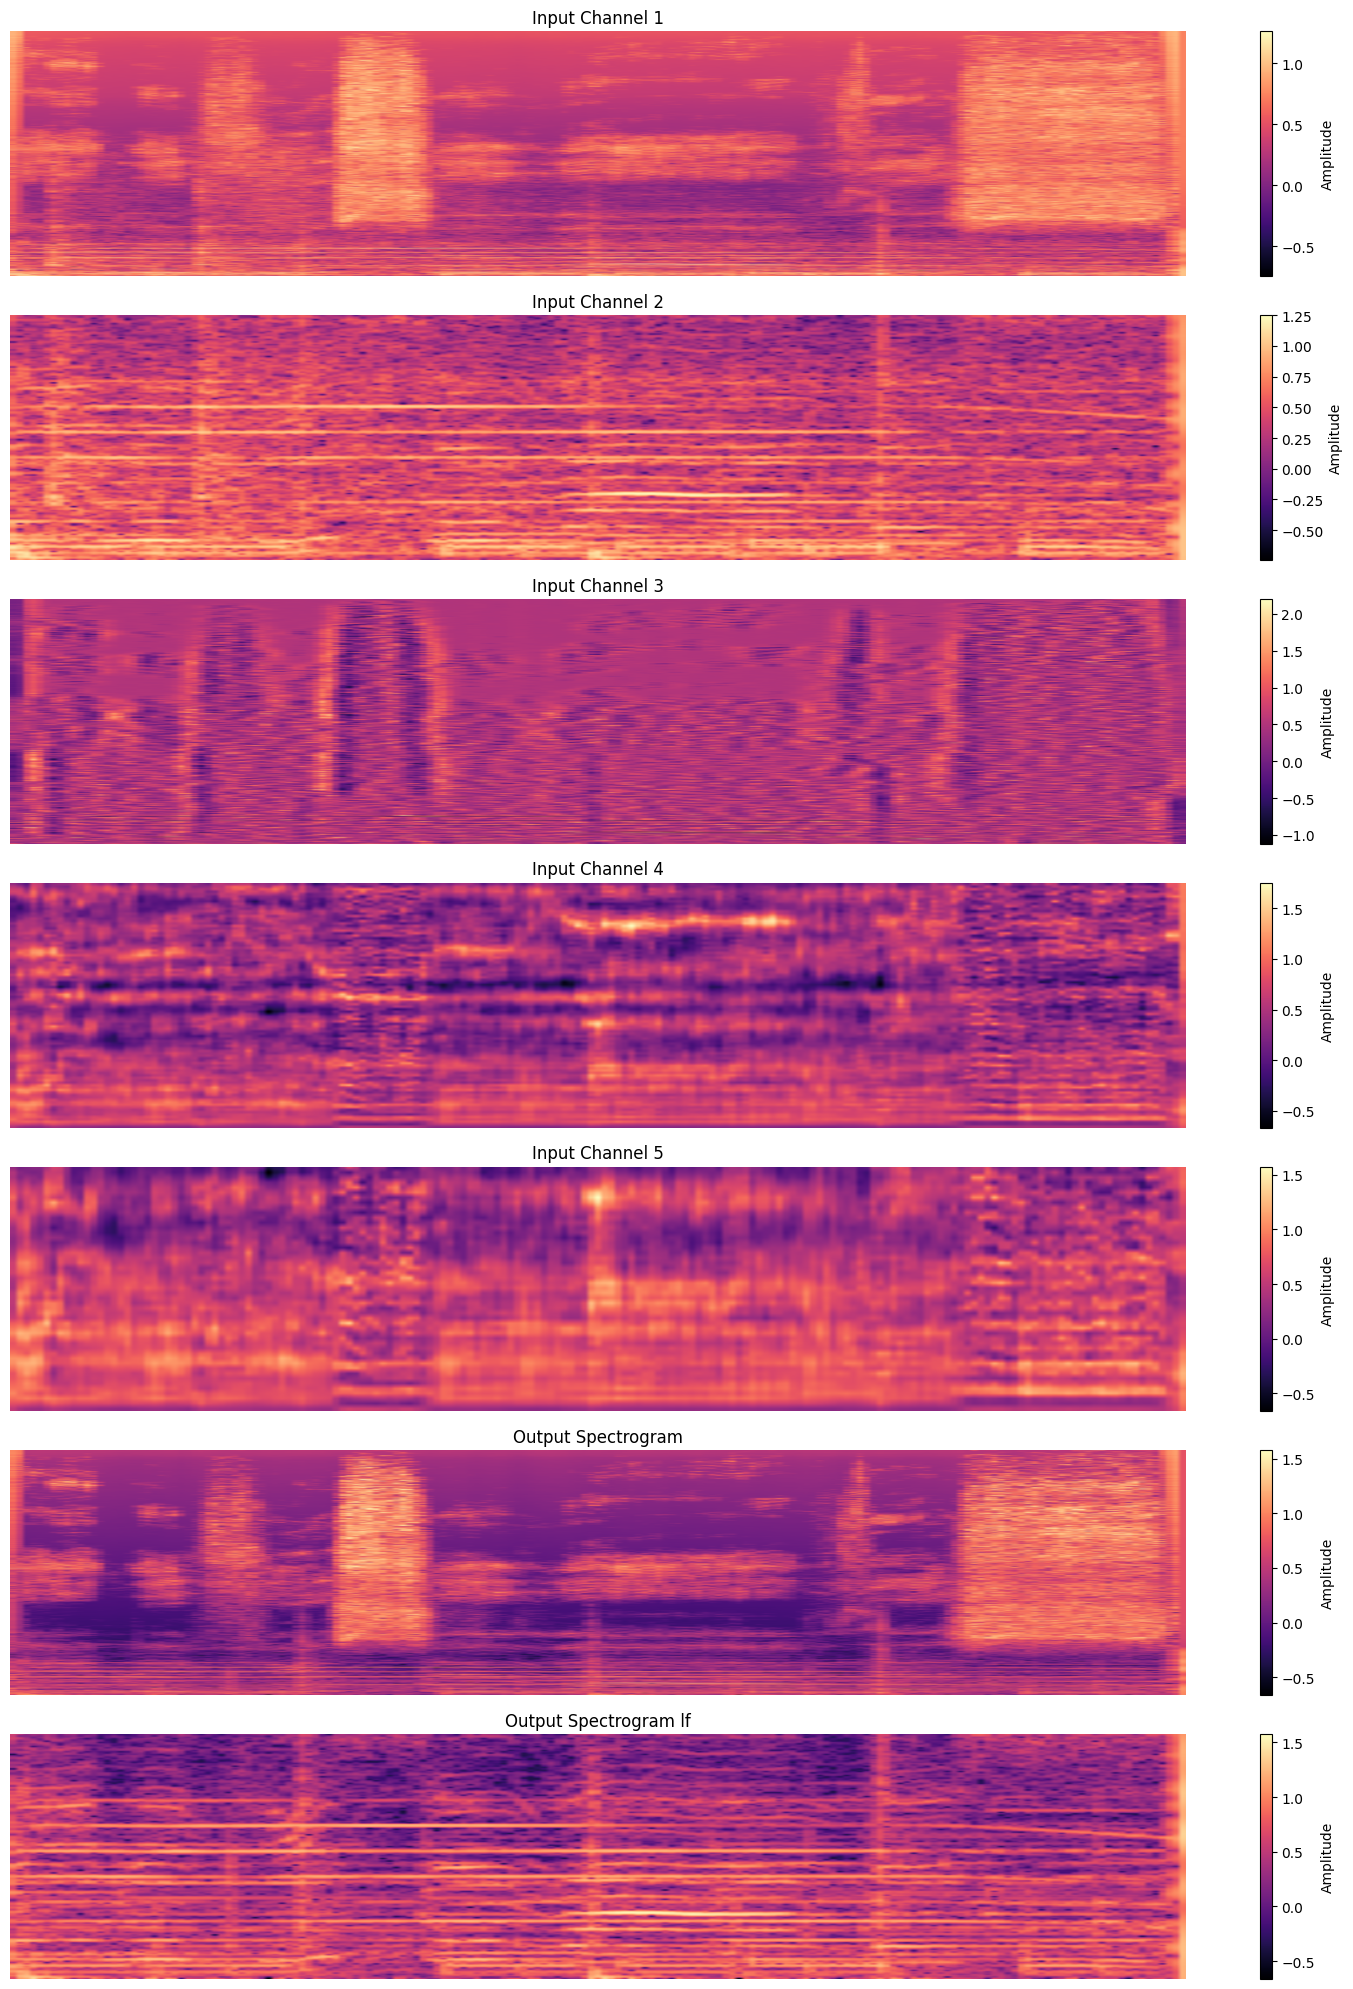

In [33]:
import matplotlib.pyplot as plt
import torch

# Fetch a sample
input_tensor, output_tensor, metadata = train_loader.train_dataset[20]

# Convert to NumPy for plotting
input_array = input_tensor.numpy()
output_array = output_tensor.numpy()

# Number of input channels
num_channels_in = input_array.shape[0]
num_channels_out = output_array.shape[0]

# Create subplots
fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 20))

# Plot each input channel
for i in range(num_channels_in):
    input = input_array[i]
    print('Min, Max: ', np.min(input), np.max(input))
    im = axes[i].imshow(input, aspect='auto', cmap='magma')
    axes[i].invert_yaxis()

    axes[i].set_title(f"Input Channel {i+1}")
    axes[i].axis("off")

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
    cbar.set_label("Amplitude")

# Plot the output spectrogram
axes[num_channels_in].imshow(output_array[0], aspect='auto', cmap='magma')
axes[num_channels_in].set_title("Output Spectrogram")
axes[num_channels_in].invert_yaxis()
axes[num_channels_in].axis("off")

# Add colorbar for output
cbar = fig.colorbar(im, ax=axes[num_channels_in], orientation="vertical")
cbar.set_label("Amplitude")

# Plot the output spectrogram
axes[num_channels_in + 1].imshow(output_array[1], aspect='auto', cmap='magma')
axes[num_channels_in + 1].set_title("Output Spectrogram lf")
axes[num_channels_in + 1].invert_yaxis()
axes[num_channels_in + 1].axis("off")

# Add colorbar for output
cbar = fig.colorbar(im, ax=axes[num_channels_in + 1], orientation="vertical")
cbar.set_label("Amplitude")

plt.tight_layout()
plt.show()


# Retrain Model

In [23]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [24]:
import torch

torch.cuda.empty_cache()

In [25]:
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv5().to(device)

print(device)

cpu


In [26]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [27]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

Training on device: cpu
Epoch 1, Current Learning Rate: [0.0001]


Training:   0%|          | 0/175 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.05


Training:   1%|          | 2/175 [01:38<2:22:17, 49.35s/batch, loss=loss: 3.9186, ref:0.2723]


KeyboardInterrupt: 

## Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv5().to(device)
denoiser = DenoisingLoader(model, load_path)
model = denoiser.model
print('Loaded Model')

# Example input (batch_size=1, channels=2, height=1025, width=175)
noisy_input = torch.randn(1, 2, 1025, 175)

denoised_output = denoiser.denoise(noisy_input)
print(denoised_output.shape)

## Testing:

In [ ]:
# Define the source and destination file paths
SNRdB = SNRdB # SNR random range
print(SNRdB)
#filename = f"train-SNRdB_{SNRdB}-1s-44-1khz-magnitude-freqweightmagnitude-phase.h5"
source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
source_path = source_folder + "test/"
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/"

save_path = source_folder + "combined_000.h5"

In [ ]:
IMPORT_TEST_NOISY = True
load_dataframe = False

In [ ]:
max_file_size_gb = 30

In [ ]:
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/"

if IMPORT_TEST_NOISY:
  if not os.path.exists(destination_path):
    combine_h5_files(source_path, destination_path, max_file_size_gb=max_file_size_gb)

View Pretrained Model Performance

In [ ]:
# checking file contents
file = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/combined_000.h5"

# Path to the HDF5 file
h5_file_path = file
n = 50
try:
    # Open the HDF5 file
    with h5py.File(h5_file_path, "r") as h5f:
        # Load 5 instances from the training and testing datasets
        input_images = h5f["input_images"][n:n+5]  # First 5 instances
        target_images = h5f["target_images"][n:n+5]  # First 5 instances
        filenames = h5f["filenames"][n:n+5]
        snr_db = h5f["snr_db"][n:n+5]

        # Convert to NumPy arrays (if not already)
        input_images = np.array(input_images)
        target_images = np.array(target_images)
        filenames = np.array(filenames)
        snr_db = np.array(snr_db)

        print("Loaded 5 training/testing instances:")
        print("Input dataset shape:", input_images.shape)
        print("Target dataset shape:", target_images.shape)

        print(filenames[0:3])
        print(snr_db[0:3])

except Exception as e:
    print("Error reading HDF5 file:", e)

In [ ]:
from audioautoencoder.datasets.utils import *

In [ ]:
if IMPORT_TEST_NOISY:
    test_loader = NoisyDatasetLoader(
        dataset_path=f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/combined_000.h5",
        output_time_length=175,
        channels=1,
        snr_db=SNRdB,
        subset=False,
        batch_size=32,
        metadata=True
    )

    print(f"Training set size: {len(test_loader.train_dataset)}")
    print(f"Validation set size: {len(test_loader.val_dataset)}")

In [ ]:
!git pull

In [ ]:
from audioautoencoder.testing import *

In [ ]:
import torch
from tqdm import tqdm
from loss import *

# Testing loop
def test_model(model, test_loader, criterion):
    evaluation = Evaluation()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        progress_bar = tqdm(test_loader, desc="Testing", unit="batch")
        for inputs, targets, metadata in progress_bar:

          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, targets)
          progress_bar.set_postfix(loss=f"{loss.item():.4f}")
          test_loss += loss.item()

          # evaluation
          evaluation.evaluate(inputs, targets, outputs, metadata)

        test_loss /= len(test_loader)

    return test_loss, evaluation.process()

import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from torchmetrics.audio import SignalDistortionRatio

class Evaluation:
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        """Initialize storage for evaluation metrics."""
        self.results = []
        self.device = torch.device(device)  # Store the device
        self.sdr = SignalDistortionRatio().to(self.device)  # Move SDR metric to the device

    def evaluate(self, inputs, targets, outputs, metadata):
        """
        Compute SDR and L1 loss for input vs. target and input vs. output.
        """
        batch_size = inputs.shape[0]
        chunk_length = 44100 * 2

        for i in range(batch_size):
            filename = metadata[i]["filename"]
            snr_db = metadata[i]["snr_db"]

            input = inputs[i].detach().cpu().numpy()
            target = targets[i].detach().cpu().numpy()
            output = outputs[i].detach().cpu().numpy()

            input_chunk = magphase_to_waveform(input[0], input[1], chunk_length)
            output_chunk = magphase_to_waveform(output[0], input[1], chunk_length)
            target_chunk = magphase_to_waveform(target[0], input[1], chunk_length)

            # Move tensors to the correct device
            input_chunk = torch.from_numpy(input_chunk).to(self.device).float()
            output_chunk = torch.from_numpy(output_chunk).to(self.device).float()
            target_chunk = torch.from_numpy(target_chunk).to(self.device).float()

            input = torch.from_numpy(input).to(self.device).float()
            output = torch.from_numpy(output).to(self.device).float()
            target = torch.from_numpy(target).to(self.device).float()

            # Compute SDR (using torchaudio)
            sdr_invstar = self.sdr(input_chunk, target_chunk).item()
            sdr_outvstar = self.sdr(output_chunk, target_chunk).item()

            # Compute L1 loss
            l1_invstar = F.l1_loss(input[0:1, :, :], target[0:1, :, :]).item()
            l1_outvstar = F.l1_loss(output[0:1, :, :], target[0:1, :, :]).item()

            # Store results
            self.results.append({
                "instance": len(self.results),
                "sdr_invstar": sdr_invstar,
                "sdr_outvstar": sdr_outvstar,
                "l1_invstar": l1_invstar,
                "l1_outvstar": l1_outvstar,
                "filename": filename,
                "snr_db": snr_db,
            })

    def process(self):
        """Return the stored evaluation results as a Pandas DataFrame."""
        return pd.DataFrame(self.results)

In [ ]:
if load_dataframe:
  df_subset = pd.read_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv")

In [ ]:
if not load_dataframe:
  criterion = nn.L1Loss()
  loss, df_eval = test_model(model, test_loader.train_loader, criterion)

In [ ]:
if not load_dataframe:
  # Assuming `df` is your original dataframe
  df_eval["Improvement"] = df_eval["sdr_outvstar"] - df_eval["sdr_invstar"]  # Higher SDR is better
  subset_columns = ["instance", "sdr_invstar", "sdr_outvstar", "l1_invstar", "l1_outvstar", "filename", "snr_db", "Improvement"]
  df_subset = df_eval[subset_columns]

In [ ]:
if not load_dataframe:
  # Create a function to map filename to a class
  def get_class_from_filename(filename, classes):
      for keyword in classes:
          if keyword in filename:
              return keyword
      return 'Unknown'  # Default if no match found

  df_subset[['filename_audio', 'filename_noise']] = pd.DataFrame(df_subset['filename'].tolist(), index=df_subset.index)
  df_subset['filename_audio'] = df_subset['filename_audio'].apply(lambda x: x.decode('utf-8'))
  df_subset['filename_noise'] = df_subset['filename_noise'].apply(lambda x: x.decode('utf-8'))

  classes = ['mixture', 'vocals', 'drums', 'guitar', 'bass', 'piano', 'electric_guitar', 'acoustic_guitar', 'synthesizer', 'strings', 'brass']
  df_subset['audio_class'] = df_subset['filename_audio'].apply(lambda x: get_class_from_filename(x, classes))

  classes = ['0707', 'Rain', 'Crowd', 'Water', 'Ice']
  df_subset['noise_class'] = df_subset['filename_noise'].apply(lambda x: get_class_from_filename(x, classes))


In [ ]:
df_subset["Improvement_L1"] = df_subset["l1_invstar"] - df_subset["l1_outvstar"]  # Lower L1 loss is better

In [ ]:
df_subset.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set minimal theme
sns.set_theme(style="white", font_scale=1.2)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_subset

# Create a grouped boxplot
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="noise_class", y="Improvement", hue="audio_class", data=df)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_all.png")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 'crowd' noise class
df_crowd = df_subset[df_subset["noise_class"] == "Crowd"].copy()

# Create a grouped boxplot
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x="audio_class", y="Improvement", hue="audio_class", data=df_crowd)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks()
#plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_crowd.png")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_eval = df_subset

# Round SNR values to the nearest 0.5 to reduce noise
df_eval["snr_db_rounded"] = df_eval["snr_db"].round(1)  # Rounds to 1 decimal place
df_eval["snr_db_rounded"] = (df_eval["snr_db_rounded"] * 2).round() / 2  # Ensures nearest 0.5

# Group by rounded SNR and audio/noise class, then compute mean improvement
df_audio_avg = df_eval.groupby(["snr_db_rounded", "audio_class"], as_index=False)["Improvement"].mean()
df_noise_avg = df_eval.groupby(["snr_db_rounded", "noise_class"], as_index=False)["Improvement"].mean()

# Line plot colored by 'audio_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_audio_avg, x="snr_db_rounded", y="Improvement", hue="audio_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Audio Class)")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

# Line plot colored by 'noise_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_noise_avg, x="snr_db_rounded", y="Improvement", hue="noise_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Noise Class)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_eval = df_subset

# Round SNR values to the nearest 0.5 to reduce noise
df_eval["snr_db_rounded"] = df_eval["snr_db"].round(1)  # Rounds to 1 decimal place
df_eval["snr_db_rounded"] = (df_eval["snr_db_rounded"] * 2).round() / 2  # Ensures nearest 0.5

# Group by rounded SNR and audio/noise class, then compute mean improvement
df_audio_avg = df_eval.groupby(["snr_db_rounded", "audio_class"], as_index=False)["Improvement_L1"].mean()
df_noise_avg = df_eval.groupby(["snr_db_rounded", "noise_class"], as_index=False)["Improvement_L1"].mean()

# Line plot colored by 'audio_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_audio_avg, x="snr_db_rounded", y="Improvement_L1", hue="audio_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Audio Class)")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

# Line plot colored by 'noise_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_noise_avg, x="snr_db_rounded", y="Improvement_L1", hue="noise_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Noise Class)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_subset

# Create a grouped boxplot
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="noise_class", y="Improvement_L1", hue="audio_class", data=df)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_all_L1.png")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 'crowd' noise class
df_crowd = df_subset[df_subset["noise_class"] == "Crowd"].copy()

# Create a grouped boxplot
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x="audio_class", y="Improvement_L1", hue="audio_class", data=df_crowd)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks()
#plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_crowd_L1.png")
plt.show()


In [ ]:
import pandas as pd

# Assuming you already have the dataframe loaded in `df`
# df = pd.read_csv('your_data.csv')  # Uncomment if loading from CSV
df = df_subset

# You can also add visualization here if you want to dive deeper
import seaborn as sns
import matplotlib.pyplot as plt

# Define a more interpretable colormap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['sdr_invstar', 'sdr_outvstar', 'l1_invstar', 'l1_outvstar', 'snr_db', 'Improvement']].corr(),
            annot=True, cmap='mako', fmt=".2f", vmin=-1, vmax=1, center=0)

plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Save subset dataframe
df_subset.to_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv", index=False)

In [ ]:
import soundfile as sf

# Filter the dataframe for rows where Improvement is greater than 3
filtered_df = df_eval[df_eval["Improvement"] > 3]

# Define the maximum number of files to write
max_files = 5

def norm(x):
  # If x is a tensor, convert it to numpy array first
  if isinstance(x, torch.Tensor):
      x = x.detach().cpu().numpy()
  return x / np.max(np.abs(x))

# Loop through the filtered rows and save the chunks to WAV files, but stop at max_files
file_count = 0
for index, row in filtered_df.iterrows():
    if file_count >= max_files:
        break  # Stop if we have written the maximum number of files

    input_chunk = row["input_chunk"]
    output_chunk = row["output_chunk"]
    target_chunk = row["target_chunk"]

    # Write to WAV files
    input_filename = f"/content/input_chunk_{index}.wav"
    output_filename = f"/content/output_chunk_{index}.wav"
    target_filename = f"/content/target_chunk_{index}.wav"

    sf.write(input_filename, norm(input_chunk), 44100)  # Assuming a sample rate of 44100 Hz
    sf.write(output_filename, norm(output_chunk), 44100)
    sf.write(target_filename, norm(target_chunk), 44100)

    # Increment the file count
    file_count += 1

# Print how many files were written
print(f"Total WAV files written: {file_count}")


# Improvements that need to be made

1. Metadata h5 column, including
- Filename
- SNR

## Convert some entire songs and test some metrics

In [ ]:
import os

whole_files = '/content/drive/MyDrive/Datasets/Music/MUSDB18/test/'
song_files = []

# Walk through the directory tree
for root, dirs, files in os.walk(whole_files):
    # Filter files with '.wav' extension and 'mixture' in their name
    for f in files:
        if f.endswith('.wav') and 'mixture' in f:
            full_path = os.path.join(root, f)
            song_files.append(full_path)

print(f"\nTotal matching files: {len(song_files)}")

Generate Audio

In [ ]:
noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits/val/Crowd Noise (1)_zkChMb.wav'

In [ ]:
from audioautoencoder.denoising import *

In [ ]:
noisy_audio, sr = generate_audio_with_noise(song_files[0], noise_file, start_time=10, duration=10)

now the answer is to digest this waveform at 1s at a time, process those seconds, at intervals of 0.5s, window the outputs and put it back together for display on spectrograms and/or for output to .wav file

In [ ]:
denoiser = AudioDenoiser(model, output_path=output_path, chunk_duration=2, step_size=0.5)
reconstructed_audio, reconstructed_input = denoiser.process_audio(noisy_audio, sr)

In [ ]:
!pip install mir_eval

Use the SDR metric to compare signal to noise ratios of the generated output, and the standard output and demonstrate an increase in signal to noise ratio overall

In [ ]:
average_rec = np.log(np.average(Pxx_rec, axis=1))
average_spec = np.log(np.average(Pxx_spec, axis=1))

plt.plot(average_rec)
plt.plot(average_spec)
plt.xscale('log')
plt.show()

import numpy as np
import mir_eval

def compute_sdr(reference, estimated):
    """
    Compute the Signal-to-Distortion Ratio (SDR) between reference and estimated signals.

    :param reference: np.ndarray of shape (channels, samples), ground-truth clean signal
    :param estimated: np.ndarray of shape (channels, samples), predicted separated signal
    :return: float, SDR value in dB
    """
    # Ensure inputs are 2D (stereo/multichannel) or 1D (mono)
    reference = np.atleast_2d(reference)
    estimated = np.atleast_2d(estimated)

    # Compute SDR using mir_eval
    sdr, _, _, _ = mir_eval.separation.bss_eval_sources(reference, estimated, compute_permutation=False)

    return np.mean(sdr)  # Return average SDR across channels

# Example usage
if __name__ == "__main__":
    # Fake reference and estimated signals (replace with actual signals)
    ref_signal = reconstructed_audio_input  # 2 channels, 1 second at 44.1kHz
    est_signal = reconstructed_audio  # Slightly noisy estimate

    # max sdr
    sdr_max = compute_sdr(audio, audio)
    print(f"SDR - : {sdr_max:.2f} dB -- Max")

    # reference sdr
    sdr_ref = compute_sdr(audio, noisy_audio)
    print(f"SDR - : {sdr_ref:.2f} dB -- Reference")

    # computed srd
    sdr_value = compute_sdr(audio, est_signal)
    print(f"SDR - : {sdr_value:.2f} dB -- Denoising")
